Wood et al. 2023

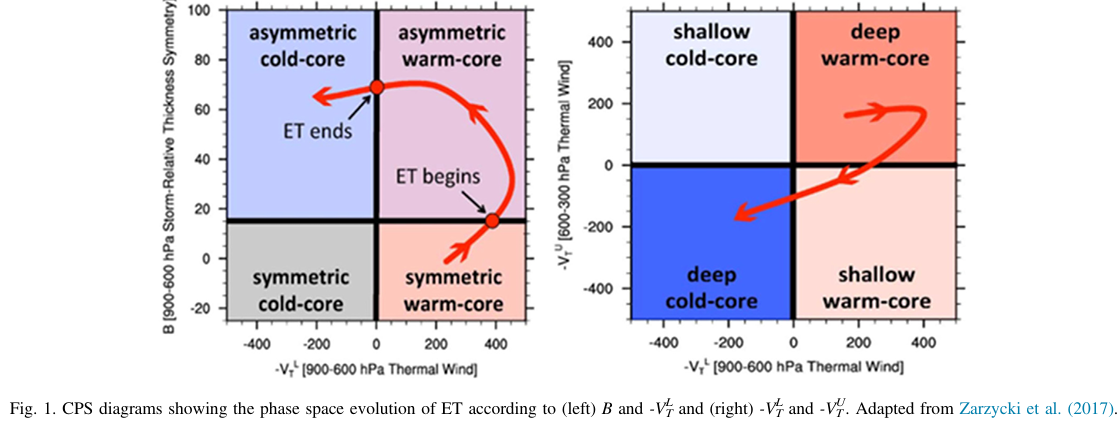

In [1]:
import os

FS = 10

dirdados = os.getcwd()+'/../DADOS/'
dirdadosCFS = os.getcwd()+'/../DADOS/CFS/'
dirdadosCFSR = os.getcwd()+'/../DADOS/CFS/CFSR/285W348E/'

dirCMEMS = os.getcwd()+'/../DADOS/MERCATOR/'
dirdadosGOBGC = os.getcwd()+'/../DADOS/GOBGC/SWAtlantic/'
dirdadosOrsi = os.getcwd()+'/../DADOS/Orsi_1995_OceanicFronts/Archive/'

dirLodiseERA5 = dirdados+'ERA5/ExtratropicalCycloneTracks_Lodise_2022/'
dirCamargoERA5 = dirdados+'ERA5/ExtratropicalCycloneTracks_Gramcianinov_e_Camargo_2020/'
dirCamargoCFS = dirdados+'CFS/ExtratropicalCycloneTracks_Gramcianinov_e_Camargo_2020/'

reanalise_escolhida = 'CFS'

#dirostia = '/home/base_de_dados/OSTIA/'

dirfigs = os.getcwd()+'/../figuras/'
dirfigsCFSR = dirfigs + 'CFS/CFSR/'

'''----------------------------------------- MY FINAL SW ATLANTIC REGION: -----------------------------------------'''
'''----------------------------------------------- 70-17°W, 65-20°S -----------------------------------------------'''

lon_i_swAtl,lon_f_swAtl = -70 , -17
 
lat_i_swAtl, lat_f_swAtl = -65, -20

In [2]:
import RussoMod as rm
import PlotaPoligonos
import parametros_cps as cps

import numpy as np
import pandas as pd
from pandas import DataFrame as DF
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import global_land_mask 
from tqdm import tqdm
from scipy.interpolate import griddata
import scipy.stats as stats
from scipy.ndimage import gaussian_filter


import cartopy.crs as ccrs
import cartopy.feature as cfeature
projecao = ccrs.PlateCarree() 
dd = display
npw = np.where

'/work/berussomano/rotinas_python/../DADOS/CFS/CFSR/'

'/work/berussomano/rotinas_python/../figuras/CFS/CFSR/'

# Reading reanalysis datasets:

CFS ATMOSPHERIC VARIABLES DOWNLOADED FROM: https://www.ncei.noaa.gov/thredds/catalog/model-cfs_reanl_6h_pgb/catalog.html

CFS OCEANIC VARIABLES DOWNLOADED FROM: https://www.ncei.noaa.gov/thredds/catalog/model-cfs_reanl_6h_ocnh/catalog.html

In [3]:
'''NOVA LEITURA DOS DADOS DO CFS: AGORA COM MAIS DE 1 ANO'''
ANOi=2001
ANOf=2010
dict_CFS = {}
dict_CFS[str(ANOi)] = {}
dict_CFS[str(ANOi)]['original'] = {}
dict_CFS[str(ANOi)]['hp'] = {}

daterange = pd.date_range(start=datetime(ANOi,1,1),end=datetime(ANOf+1,1,1), freq='3H')[:-1]

#--------------------------------------------------------------------------------------------

filename = (dirdadosCFSR+'pkl/original/CFSR_gph_'+daterange[0].strftime("%Y%m%d_%HZ")+'a'+daterange[-1].strftime("%Y%m%d_%HZ")+
            '.pkl')
load = pd.read_pickle(filename)
print(load['gph'][:,:,:,:].shape)
dict_CFS[str(ANOi)]['original']['gph'] = load['gph'][:,:,:,:]
dict_CFS[str(ANOi)]['time_atm'] = load['daterange']
dict_CFS['isobaric'] = load['isobaric'][:]
dict_CFS['lon_atm'] = load['lon_atm'][:]
dict_CFS['lat_atm'] = load['lat_atm'][:]
            

for var in ['lh_surf','slp']:

    print(var)

    filename = (dirdadosCFSR+'pkl/hp15d/CFSR_'+var+'_'+daterange[0].strftime("%Y%m%d_%HZ")+'a'+daterange[-1].strftime("%Y%m%d_%HZ")+
            '.pkl')
    load = pd.read_pickle(filename)
    if var in ['wnd850','vor_atm850']:
        var = var[:-3]
        dict_CFS[str(ANOi)]['hp'][var+'850'] = load[var+'_120'][:,:,:] 
    else:
        dict_CFS[str(ANOi)]['hp'][var] = load[var+'_120'][:,:,:] 

    print(load[var+'_120'].shape)
    
    if var !=  'vor_atm':
        dict_CFS[str(ANOi)]['original'][var] = load[var][:,:,:]
    if var ==  'wnd':
        dict_CFS[str(ANOi)]['original'][var+'850'] = load[var][:,:,:]        
        
    dict_CFS['lon_atm'] = load['lon_atm'][:]
    dict_CFS['lat_atm'] = load['lat_atm'][:]


    
for var in ['sst']:

    print(var)
            
    filename = (dirdadosCFSR+'pkl/hp15d/CFSR_'+var+'_'+(daterange[0]+timedelta(hours=1)).strftime("%Y%m%d_%HZ")+'a'+(daterange[-1]+timedelta(hours=1)).strftime("%Y%m%d_%HZ")+
                '.pkl')
    
        
    load = pd.read_pickle(filename)
    print(load[var+'_120'].shape)
    dict_CFS[str(ANOi)]['hp'][var] = load[var+'_120'][:,:,:]
    dict_CFS[str(ANOi)]['original'][var] = load[var][:,:,:]
    dict_CFS['lon_ocn'] = load['lon_ocn'][:]
    dict_CFS['lat_ocn'] = load['lat_ocn'][:]
            
    
print()
print('---------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------')
print('------------------------------ATTENTION: the fields must be in the following format:------------------------------')
print()

print('dict_CFS.keys():',dict_CFS.keys())
print()
print('dict_CFS[str(ANOi)].keys():',dict_CFS[str(ANOi)].keys())
print()
print("dict_CFS[str(ANOi)]['original'].keys():", dict_CFS[str(ANOi)]['original'].keys())
print()

print("dict_CFS['isobaric']:",dict_CFS['isobaric'],' // shape:',dict_CFS['isobaric'].shape)
print()

print("dict_CFS['lat_atm'].shape:",dict_CFS['lat_atm'].shape)
print()
print("dict_CFS['lon_atm'].shape:",dict_CFS['lon_atm'].shape)
print()


print("dict_CFS['lat_ocn'].shape:",dict_CFS['lat_ocn'].shape)
print()
print("dict_CFS['lon_ocn'].shape:",dict_CFS['lon_ocn'].shape)
print()


print("dict_CFS[str(ANOi)]['original']['gph'].shape:", dict_CFS[str(ANOi)]['original']['gph'].shape,' = (VALUE, ISOB LEVEL, LAT_ATM, LON_ATM)')
print("dict_CFS[str(ANOi)]['original']['sst'].shape:", dict_CFS[str(ANOi)]['original']['sst'].shape,' = (VALUE, LAT_OCN, LON_OCN)')



(29216, 21, 56, 64)
lh_surf
(29216, 56, 64)
slp
(29216, 56, 64)
sst
(29216, 111, 127)

---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
------------------------------ATTENTION: the fields must be in the following format:------------------------------

dict_CFS.keys(): dict_keys(['2001', 'isobaric', 'lon_atm', 'lat_atm', 'lon_ocn', 'lat_ocn'])

dict_CFS[str(ANOi)].keys(): dict_keys(['original', 'hp', 'time_atm'])

dict_CFS[str(ANOi)]['original'].keys(): dict_keys(['gph', 'lh_surf', 'slp', 'sst'])

dict_CFS['isobaric']: [ 250.  300.  350.  400.  450.  500.  550.  600.  650.  700.  750.  775.
  800.  825.  850.  875.  900.  925.  950.  975. 1000.]  // shape: (21,)

dict_CFS['lat_atm'].shape: (56,)

dict_CFS['lon_atm'].shape: (64,)

dict_CFS['lat_ocn'].shape: (111,)

dict_CFS['lon_ocn'].shape: (127,)

dict_CFS[str(ANO

_____________________________
# CREATING AND VISUALIZING THE POLYGONS:

In [4]:
lon_i, lon_f = -179.99, 179.943
lat_i, lat_f = -82.344, -17.294
lon_i_atl,lon_f_atl = -75, 20   
lat_i_atl, lat_f_atl = -90, -5    

lat_lim_antartica = -60

lon_i_africa, lon_f_africa = 0, 25
lat_i_africa, lat_f_africa = -40, -20#-22

'''----------------------------------------- MY FINAL SW ATLANTIC REGION: -----------------------------------------'''
'''----------------------------------------------- 70-17°W, 65-20°S -----------------------------------------------'''

lon_i_swAtl,lon_f_swAtl = -70 , -17
 
lat_i_swAtl, lat_f_swAtl = -65, -20

orsi = rm.le_orsi_swatl()


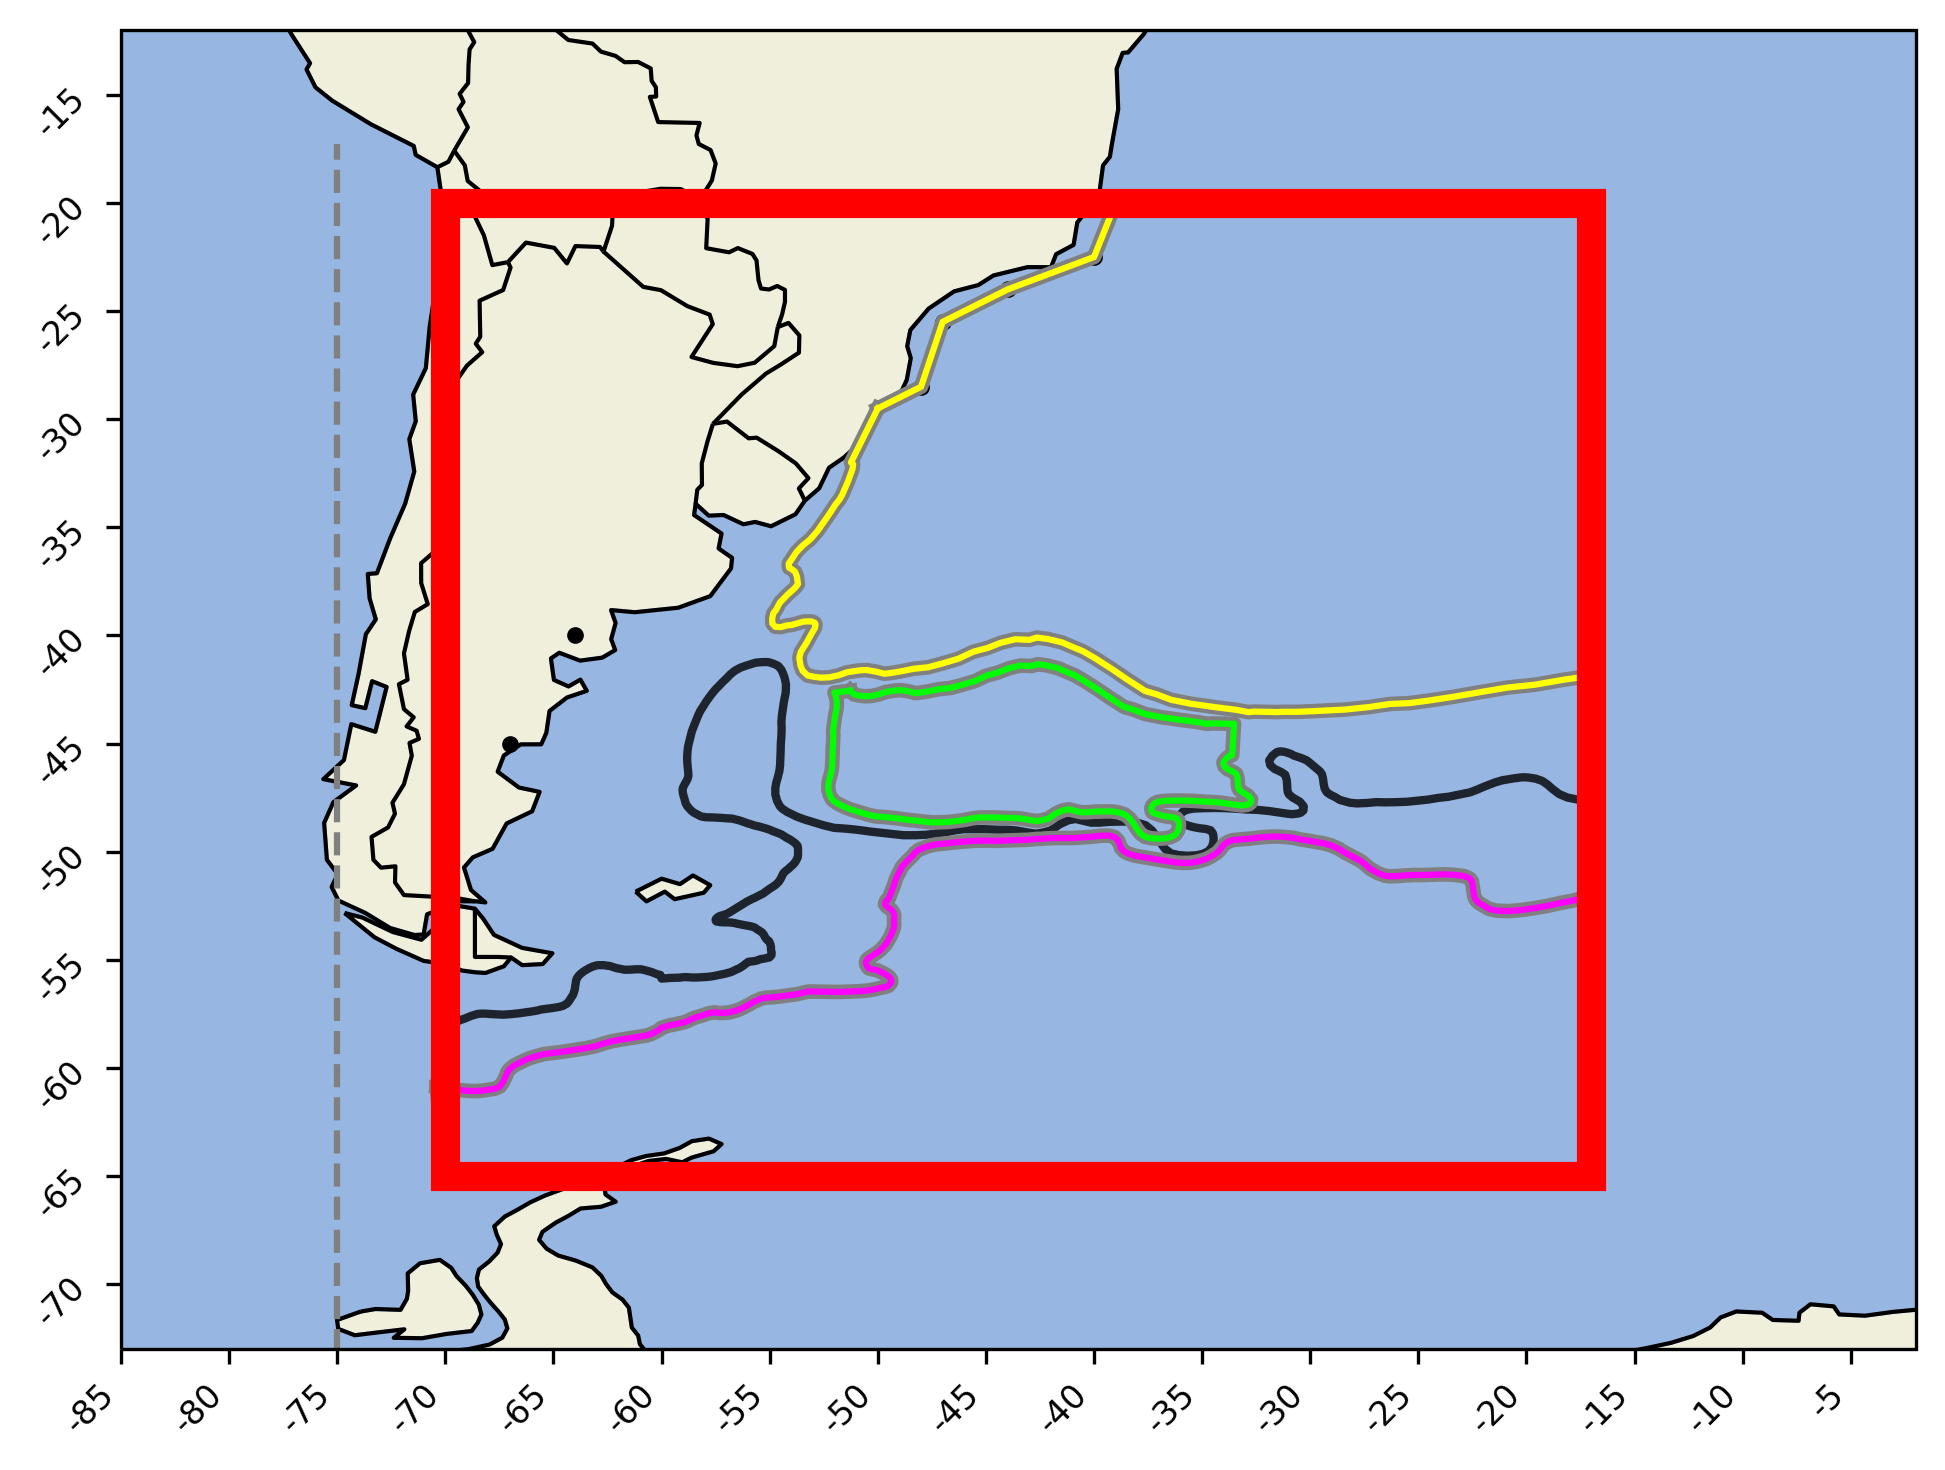

In [5]:
'''--------------------------------------------POLYGONS--------------------------------------------'''

fig, ax = plt.subplots(subplot_kw={'projection': projecao}, 
                       dpi=300)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

xticks=range(-100, 20, 5)
yticks=range(int(lat_i_atl), int(lat_f_atl), 5)

ax.set_xticks(xticks, crs=projecao)
ax.set_yticks(yticks, crs=projecao)
ax.set_xticklabels(xticks, rotation=45, ha='right',fontsize=8)
ax.set_yticklabels(yticks, rotation=45, ha='right',fontsize=8)

ax.vlines(x=[lon_i_atl,lon_f_atl],ymin=lat_i,ymax=lat_f,ls='--',color = 'grey')

PlotaPoligonos.plota_poligonos(escolhidos=['SWATL'],ax=ax)

plt.tight_layout()

rm.plota_orsi_swatl(ax)

#CHECKING POINTS TO CLOSE THE POLYGONS OF STF AND PF IN THE FOLLOWING CELLS! NECESSARY FOR THE inpolygon FUNCTION
plt.plot(-39,lat_f_swAtl,marker='o',markersize=3,color='k')
plt.plot(-40,-22.5,marker='o',markersize=3,color='k')
plt.plot(-44,-24  ,marker='o',markersize=3,color='k')
plt.plot(-47,-25.5,marker='o',markersize=3,color='k')
plt.plot(-48,-28.5,marker='o',markersize=3,color='k')
close_stf_lons = np.array([                      -39,   -40  ,  -44,   -47  ,   -48  ])
close_stf_lats = np.array([              lat_f_swAtl,   -22.5,  -24,   -25.5,   -28.5])

plt.plot(lon_i_swAtl,lat_i_swAtl,marker='o',markersize=3,color='k')
plt.plot(lon_f_swAtl,lat_i_swAtl,marker='o',markersize=3,color='k')
close_pf_lons = np.array([lon_f_swAtl, lon_i_swAtl])
close_pf_lats = np.array([lat_i_swAtl, lat_i_swAtl])

plt.plot(-64,-40,marker='o',markersize=3,color='k')
plt.plot(-67,-45,marker='o',markersize=3,color='k')

close_saf_lons = np.array([-67,-62.5])
close_saf_lats = np.array([-45,-40])

plt.ylim([(lat_i_swAtl)-8, (lat_f_swAtl)+8])
plt.xlim([-85,-2])

rm.NorthSTFPolygon(ax,True)
rm.ReducedZapiolaPolygon(ax,0.8,print_polygon=True)
rm.NorthACCPolygon(ax,1.0,True)

plt.show()



_____________

# READING CYCLONE DATASET AND SELECTING THE ONES INSIDE THE POLYGONS:

# Gramcianinov et al (2020): Camargo dataset
https://data.mendeley.com/datasets/kwcvfr52hp/1

- **columns: track id, date (UTC), longitude (0 - 360º), latitude, T42 vorticity** 
    
- **track id**: the tracks are numbered by year, following the format of YYYYXXXX. E.g., 19790001 is the first track of 1979. In this way, each cyclone/track has a unique ID in the database
    
 - the tracks are organized in monthly files, which contains all tracks that start in the selected month, even if it ends in the next one.
    
 - **T42 vorticity**: is the central minimum vorticity used to the cyclone detection. It is not the "real" vorticity, but the filtered vorticity used during the identification process and tracking (see Hoskins and Hodges 2002).

In [6]:
meses = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}
contagem = {}
dirfigs_track = dirfigs+reanalise_escolhida+'/'


In [7]:
save_storms = False
ANOi_esc=2001
ANOf_esc=2002

'Original Dataframe (Gramcianinov et al., 2020)'

ID  Longitude  Latitude  T42 vorticity                Time
0       1    -62.440   -55.523          2.024 2001-01-01 06:00:00
1       1    -61.041   -55.030          2.134 2001-01-01 07:00:00
2       1    -60.061   -54.662          2.240 2001-01-01 08:00:00
3       1    -59.418   -54.346          2.320 2001-01-01 09:00:00
4       1    -58.852   -54.081          2.346 2001-01-01 10:00:00
...   ...        ...       ...            ...                 ...
5717  689    -57.214   -62.263          2.569 2002-01-02 01:00:00
5718  689    -56.738   -62.622          2.390 2002-01-02 02:00:00
5719  689    -56.243   -63.055          2.217 2002-01-02 03:00:00
5720  689    -55.717   -63.683          2.042 2002-01-02 04:00:00
5721  689    -55.189   -64.493          1.930 2002-01-02 05:00:00

[55732 rows x 5 columns]

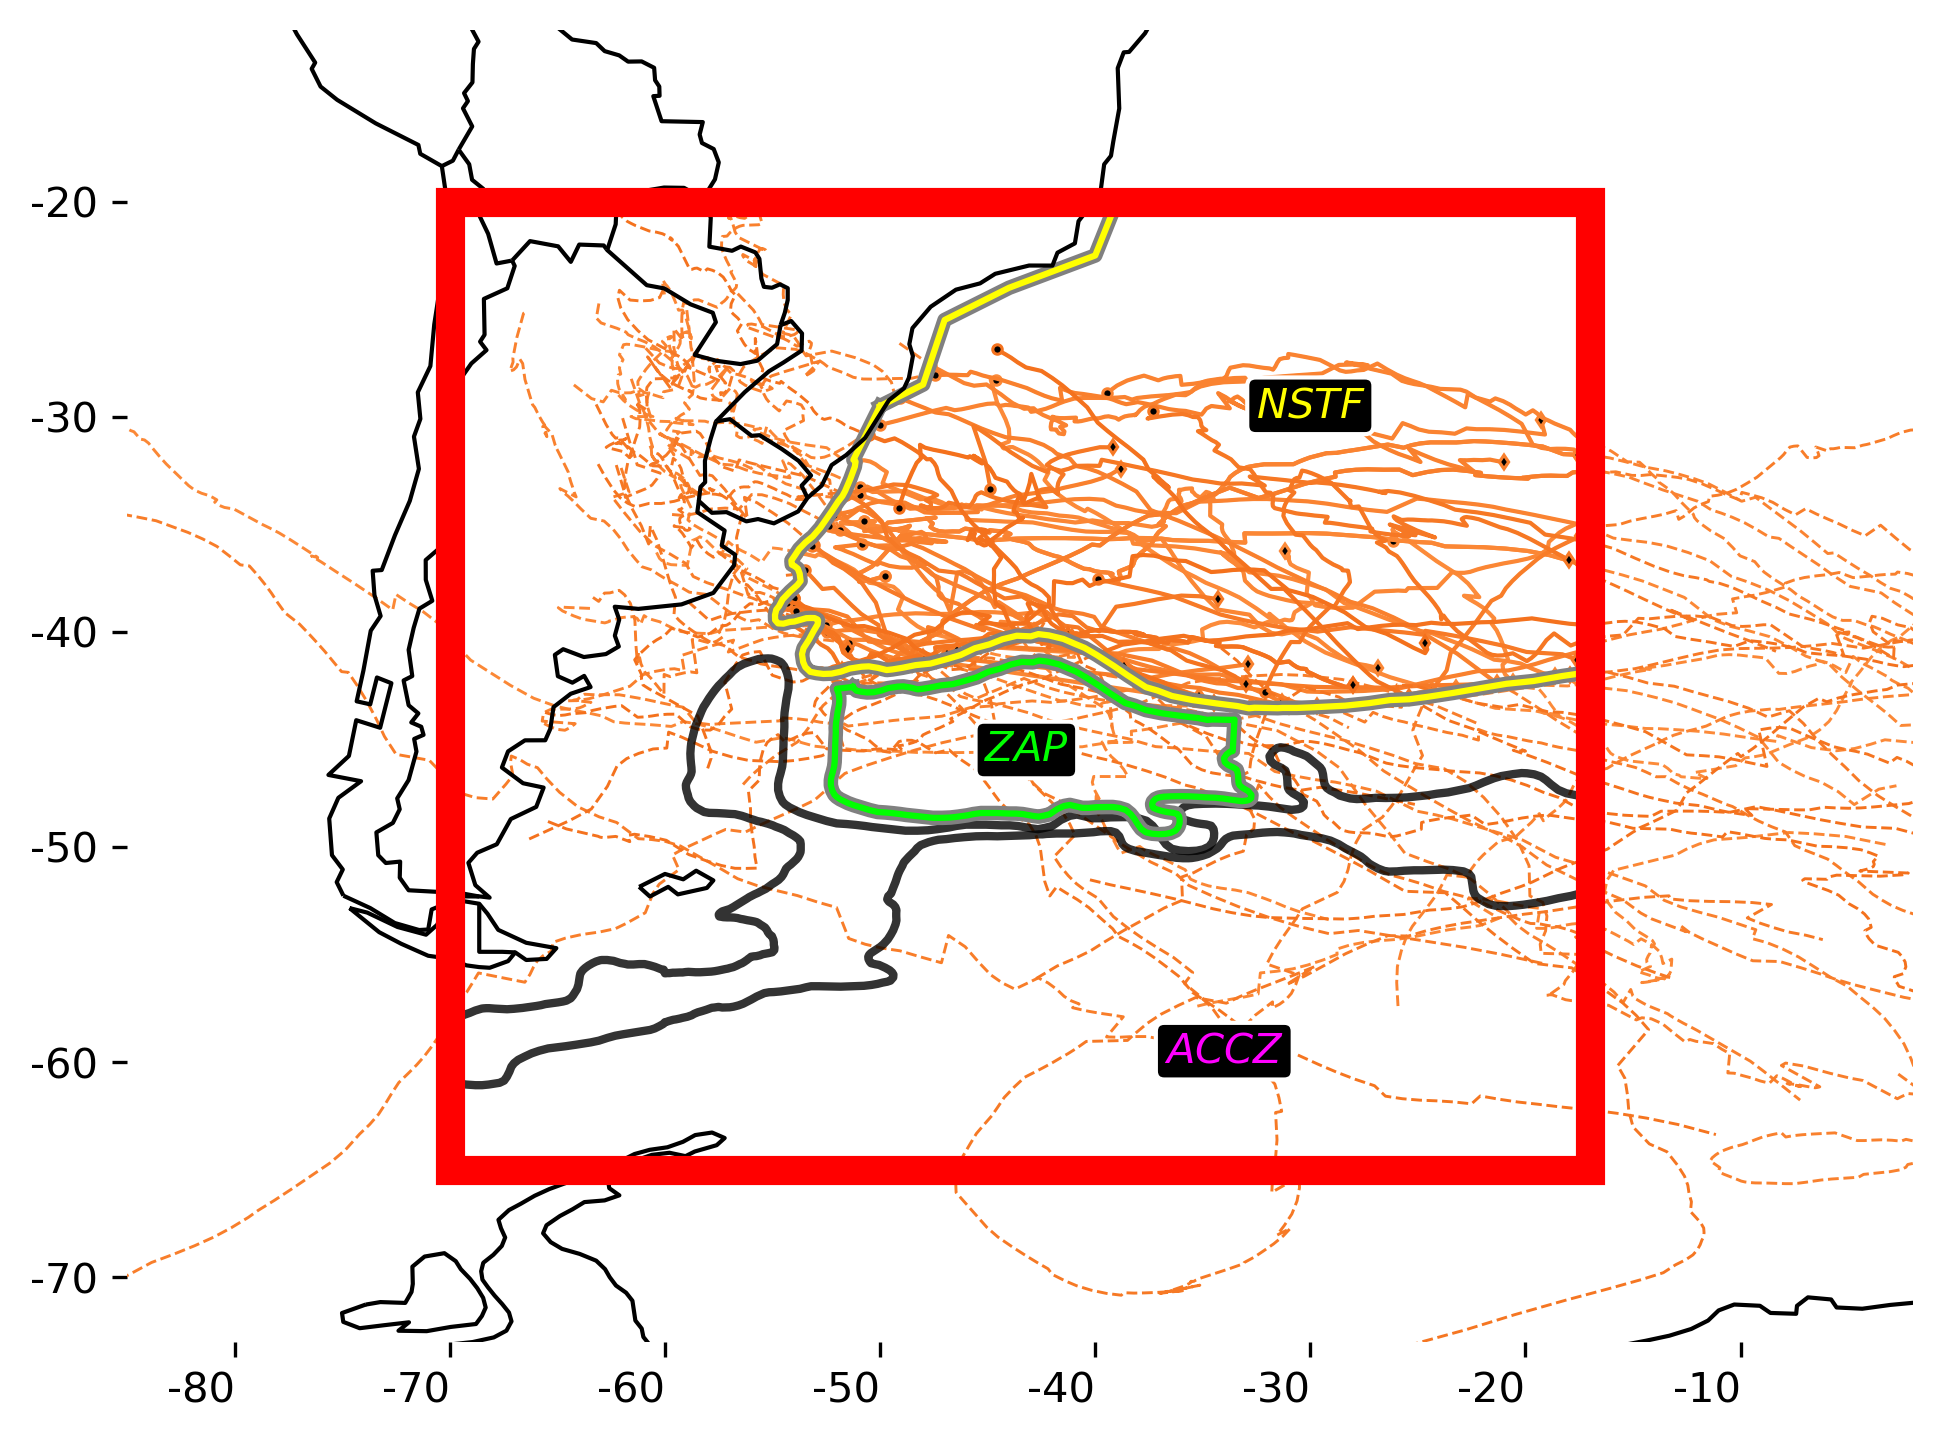

{2001: array([ 40,  46,  74, 118, 135, 140, 161, 162, 185, 203, 217, 223, 229,
       234, 240, 251, 271, 294, 295, 301, 303, 313, 318, 355, 368, 373,
       386, 388, 399, 440, 449, 454, 464, 467, 470, 496, 502, 504, 511,
       536, 563, 565, 588, 602, 625, 634, 635, 639, 648, 658, 669])}


'Dataframe after applying the conditions:'

ID  Longitude  Latitude  T42 vorticity                Time
3284   40    -53.849   -36.308          3.911 2001-01-28 03:00:00
3285   40    -53.402   -36.395          4.084 2001-01-28 04:00:00
3286   40    -53.017   -36.488          4.270 2001-01-28 05:00:00
3287   40    -52.869   -36.389          4.745 2001-01-28 06:00:00
3288   40    -52.565   -36.488          4.851 2001-01-28 07:00:00
...   ...        ...       ...            ...                 ...
3366  669    -36.210   -42.641          8.485 2001-12-23 06:00:00
3367  669    -35.799   -42.801          8.607 2001-12-23 07:00:00
3368  669    -35.390   -42.993          8.683 2001-12-23 08:00:00
3369  669    -34.969   -43.176          8.686 2001-12-23 09:00:00
3370  669    -34.458   -43.286          8.661 2001-12-23 10:00:00

[2820 rows x 5 columns]

'Original Dataframe (Gramcianinov et al., 2020)'

ID  Longitude  Latitude  T42 vorticity                Time
0       1   -155.942   -45.417          4.748 2002-01-01 00:00:00
1       1   -155.378   -45.446          4.735 2002-01-01 01:00:00
2       1   -154.814   -45.422          4.692 2002-01-01 02:00:00
3       1   -154.265   -45.367          4.623 2002-01-01 03:00:00
4       1   -153.647   -45.375          4.507 2002-01-01 04:00:00
...   ...        ...       ...            ...                 ...
4848  692      3.218   -46.835          2.139 2003-01-02 00:00:00
4849  692      4.120   -46.869          2.039 2003-01-02 01:00:00
4850  692      5.091   -46.981          1.934 2003-01-02 02:00:00
4851  692      6.092   -47.204          1.833 2003-01-02 03:00:00
4852  692      7.124   -47.664          1.717 2003-01-02 04:00:00

[58862 rows x 5 columns]

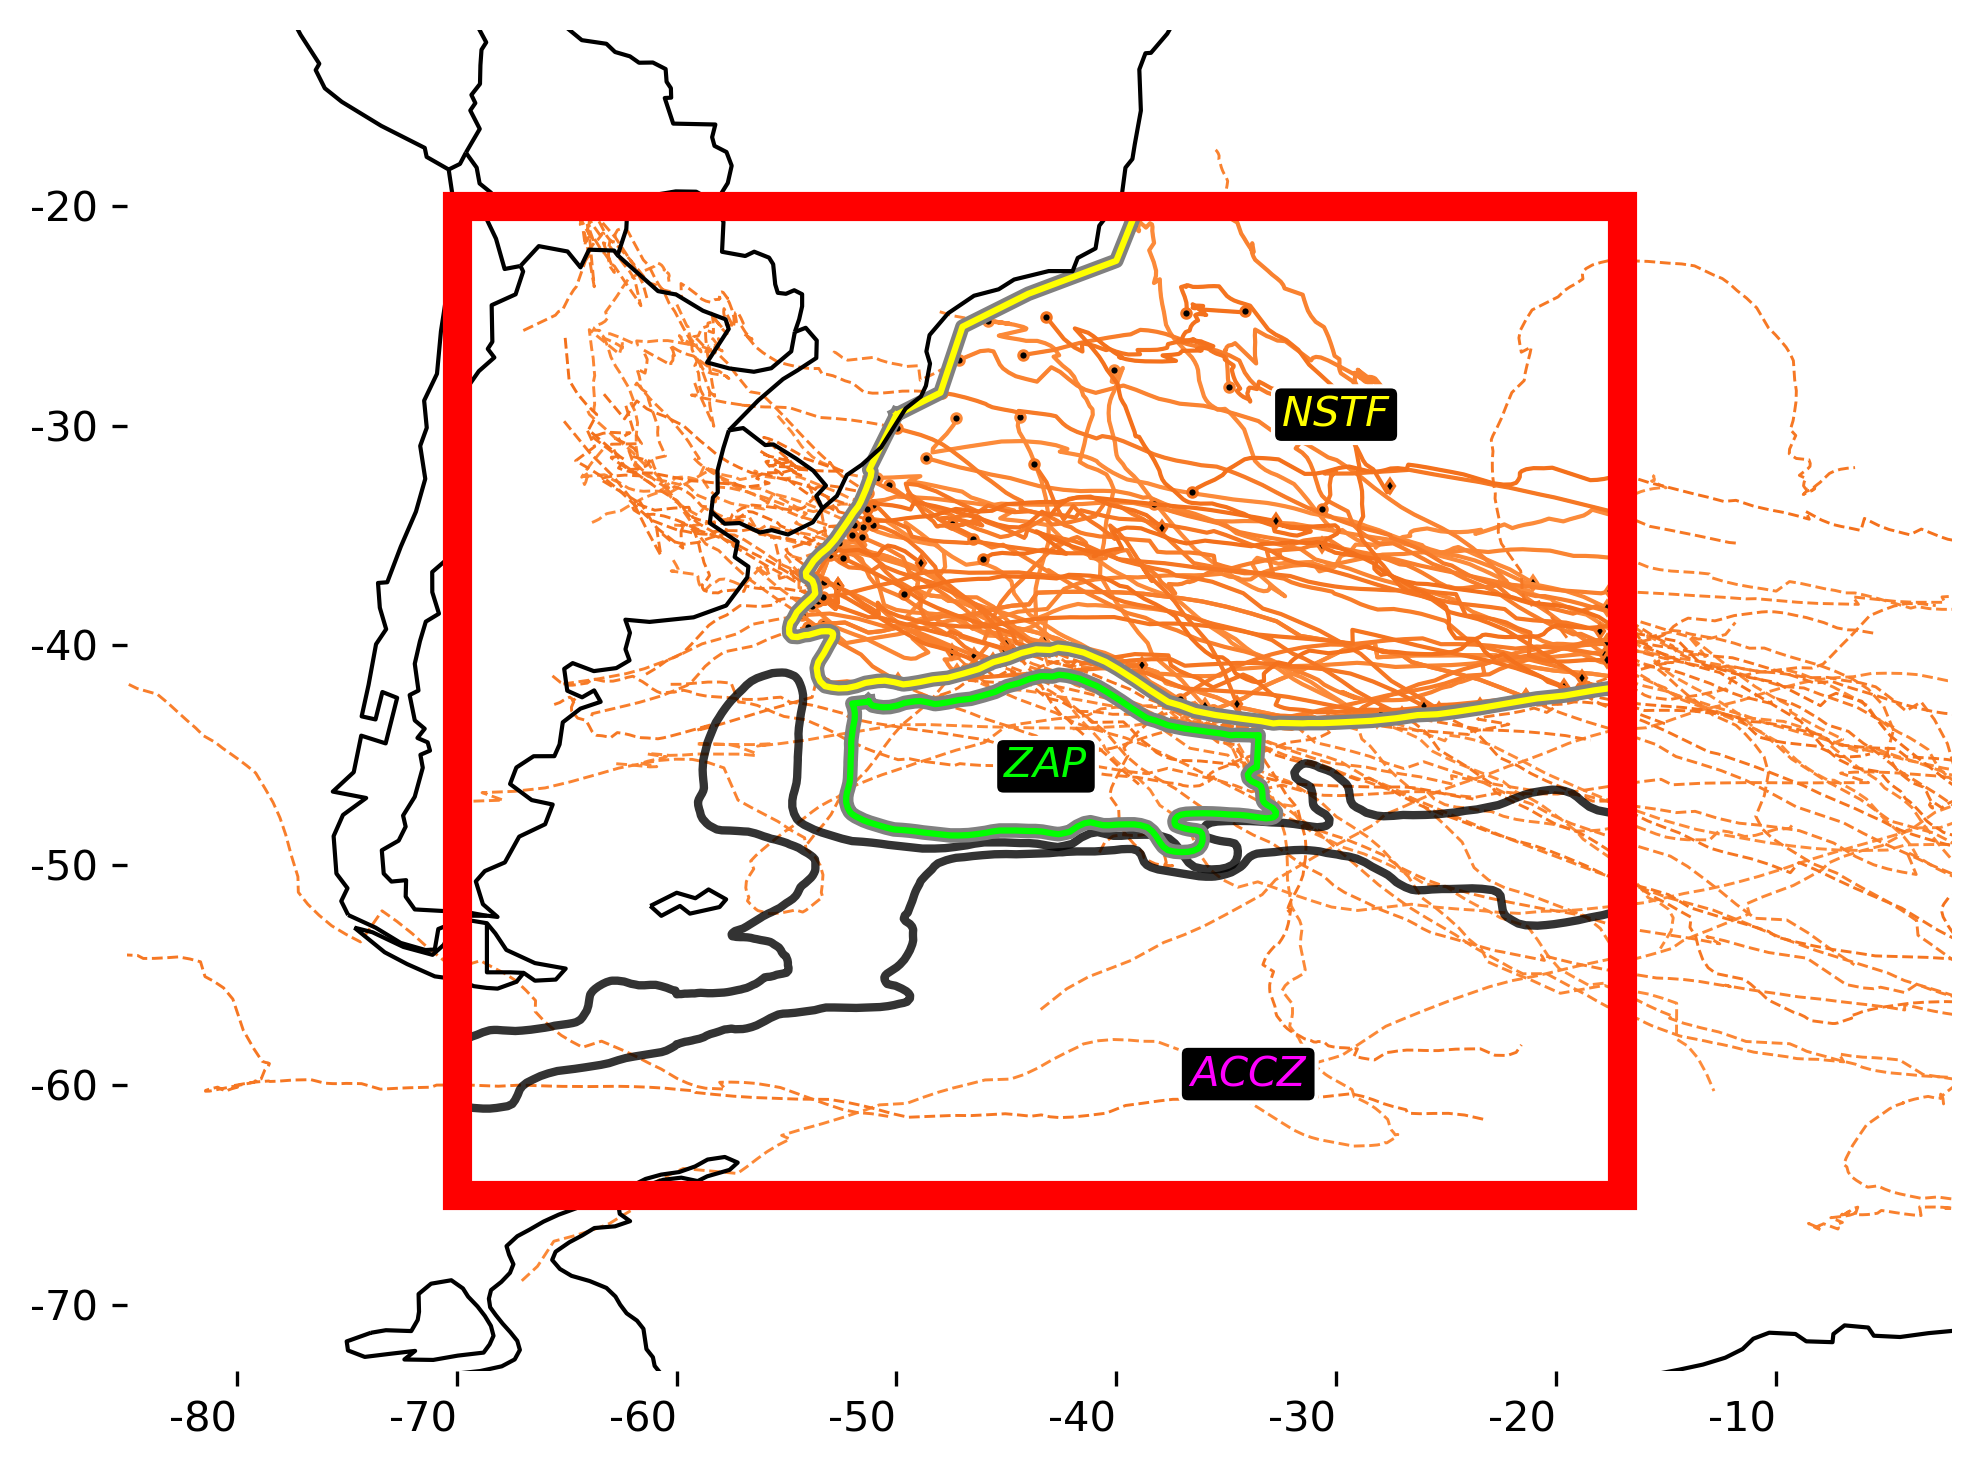

{2001: array([ 40,  46,  74, 118, 135, 140, 161, 162, 185, 203, 217, 223, 229,
       234, 240, 251, 271, 294, 295, 301, 303, 313, 318, 355, 368, 373,
       386, 388, 399, 440, 449, 454, 464, 467, 470, 496, 502, 504, 511,
       536, 563, 565, 588, 602, 625, 634, 635, 639, 648, 658, 669]), 2002: array([  8,  28,  42,  44,  49,  57,  71,  92, 128, 136, 157, 169, 183,
       197, 198, 207, 216, 219, 223, 264, 270, 282, 299, 308, 310, 323,
       332, 344, 367, 374, 379, 395, 397, 406, 407, 414, 421, 467, 489,
       496, 505, 512, 516, 517, 522, 534, 538, 546, 559, 569, 574, 584,
       588, 598, 602, 629, 657, 660, 669, 676, 679, 688])}


'Dataframe after applying the conditions:'

ID  Longitude  Latitude  T42 vorticity                Time
755     8    -51.673   -33.576          4.815 2002-01-07 01:00:00
756     8    -51.606   -33.716          4.656 2002-01-07 02:00:00
757     8    -51.512   -33.892          4.480 2002-01-07 03:00:00
758     8    -51.341   -34.061          4.332 2002-01-07 04:00:00
759     8    -51.118   -34.242          4.210 2002-01-07 05:00:00
...   ...        ...       ...            ...                 ...
4612  688    -36.480   -33.736          5.278 2003-01-02 13:00:00
4613  688    -35.725   -33.835          5.417 2003-01-02 14:00:00
4614  688    -34.758   -33.989          5.531 2003-01-02 15:00:00
4615  688    -33.531   -34.194          5.688 2003-01-02 16:00:00
4616  688    -32.730   -34.344          5.879 2003-01-02 17:00:00

[3084 rows x 5 columns]

In [43]:
'''-------------------------PLOTANDO STORM TRACKS-------------------------'''
'''ESSA CÉLULA DESTACA APENAS OS CICLONES DE INTERESSE'''
SAVEFIGTRACK = False

zone = 'stf'#'shelf';'npf';#'stf' #'zap'#input('zap,stf,saz,pfz, acc or swAtl? ') #--------------OR None
plot_just_in_region = True

run_ocean_below_function = False
#original_ou_filt = 'hp'

anota_data = False #Para anotar a data e hora no plot, sobre o marker
anota_id = False

ms=2
lw=0.5
#-------------------DEFINE HERE THE CHOSEN SEASON
mes_unico = [2,3] #ALTERAR AQUI CASO QUEIRA UM UNICO MES
Summer = [1,2,3]
SummerPeak = [2,3,4]
Fall = [4,5,6]
Winter = [7,8,9]
WinterPeak = [8,9,10]
Spring = [10,11,12]
AllYear = np.arange(1,12+1)

season = AllYear #ALTERAR AQUI
#-------------------DEFINE HERE THE CHOSEN SEASON

CONDICAO = 18 #ALTERAR AQUI

min_lifetime = 24
max_lifetime = 999 #apenas para analisar
min_vortmed = 2
min_vortmax = 5.5
min_steps_at_swAtl = 24
dia_ref_ocean = 0

IDs_dict = {}#[]
storm_data_final_years = {}
storm_data_final_allyears = DF() #NECESSARY FOR THE PLOT OF THE TIME SERIES
storm_data_final_in_region_years = {}
storm_data_final_in_region_allyears = DF() #NECESSARY FOR THE PLOT OF THE TIME SERIES

for ANO in range(ANOi_esc,ANOf_esc+1):
    dd('Original Dataframe (Gramcianinov et al., 2020)')
    camargo,ano_esc = rm.le_tracking_camargo(ANO,ANO)

    FS=12 #fontsize

    df_ciclones = camargo#argosloc#camargo
    storm_data_final = DF()
    storm_data_final_in_region = DF()

    storm_id_i = 1 #1#CICLONE INICIAL DO LOOP #NUMERO NA COLUNA Storm ID DO DATAFRAME df_ciclones['Storm ID']
    storm_id_f = df_ciclones['ID'].unique()[-1] #CICLONE FINAL DO LOOP #O ULTIMO DE TODOS É: df_ciclones['Storm ID'].unique()[-1]

    
    if CONDICAO == 11:
        tempo_minimo = int(input('Tempo de vida mínimo (horas) no Atlantico Sul (acima de 60°S):'))

    if CONDICAO == 17:
        min_lifetime = 24

    '''DEFINA AQUI O PERIODO (MESES DE 1 a 12) ESCOLHIDO EM FORMATO LISTA'''
    for periodo_esc in [season]:

        periodo_esc_str = ''.join(meses[mes] for mes in periodo_esc) #TRANSFORMA NA INICIAL DO MES PARA TITULO

        for condicao_localizacao in [CONDICAO]:
            
            '----------------INICIANDO FIGURA'
            fig, ax = plt.subplots(subplot_kw={'projection': projecao}, 
                                   dpi=300)


            '----------------INSERINDO LOOP DE CORES'
            cmap = plt.cm.gist_rainbow
            cmap = plt.cm.Oranges#
            cmap = mcolors.LinearSegmentedColormap.from_list('OrangesTopHalf', cmap(np.linspace(0.5, 0.6, 256)))
            
            "----------------INICIANDO LOOP SOBRE OS VALORES ÚNICOS DA lodise['Storm ID']"
            #O COMANDO .unique() FAZ COM QUE LOCALIZA APENAS 1, EM VEZ DE VARIAS REPETIÇÕES COMO NO DF ORIGINAL
            #O COMANDO .unique() NOS DÁ O TOTAL DE CICLONES QUE ELA TRACKEOU COM lodise['Storm ID'].unique()[-1]
            #EXEMPLO: Para ver apenas a primeira tempestade, basta que storm_id_i = 1 e storm_id_f = 1 

            contagem['Cond '+str(condicao_localizacao)] = []
            
            for mes_esc in periodo_esc:

                for i, storm_id in enumerate(df_ciclones['ID'].unique()):#[stormid_i:stormid_f]:
                    if storm_id in np.arange(storm_id_i,storm_id_f+1):
                        #DESTACANDO UMA TEMPESTADE NO LOOP
                        storm_data = df_ciclones[df_ciclones['ID'] == storm_id] 

                        if ((len(storm_data['Time']) >= min_lifetime) and 
                           (len(storm_data['Time']) <= max_lifetime) and 
                           ((np.nanmax(storm_data['T42 vorticity'])) >= min_vortmax)): #EXCLUINDO OS QUE DURAM MENOS QUE 36 HORAS 
                                

                            #DESTACANDO CICLONES COM INICIO NO MES DEFINIDO
                            if (pd.to_datetime((storm_data['Time'].iloc[0])).month == mes_esc):#O MES INICIAL DO CICLONE DEVE SER ESSE
                                
                                if condicao_localizacao == 1:
                                    desc = 'começam e terminam no Atlantico'
                                    '''CONDICIONANDO LOCALIZAÇÃO 1:
                                    Ciclones que -começam e terminam- no Atlântico Sul.'''
                                    is_storm_within_domain = all(
                                        (storm_data['Longitude'] >= lon_i_atl) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_i_atl) & (storm_data['Latitude'] <= lat_f_atl))



                                elif condicao_localizacao == 2:
                                    desc = 'terminam no Atlantico'
                                    '''CONDICIONANDO LOCALIZAÇÃO 2:
                                    Ciclones apenas que -terminam- no Atlântico Sul: 
                                    podem iniciar no Pacífico.'''
                                    is_storm_within_domain = (
                                        (storm_data['Longitude'].iloc[-1] >= lon_i_atl) & (storm_data['Longitude'].iloc[-1] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'].iloc[-1] >= lat_i_atl) & (storm_data['Latitude'].iloc[-1] <= lat_f_atl))



                                elif condicao_localizacao == 3:
                                    desc = 'passam pelo Atlantico'
                                    '''CONDICIONANDO LOCALIZAÇÃO 3:
                                    Ciclones que -passam- pelo Atlântico Sul: 
                                    podem iniciar no Pacífico ou terminar no Índico.'''
                                    is_storm_within_domain = any(
                                        (storm_data['Longitude'] >= lon_i_atl) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_i_atl) & (storm_data['Latitude'] <= lat_f_atl))



                                elif condicao_localizacao == 4:
                                    desc = 'passam pelo menos metade da sua vida no Atlantico'
                                    '''CONDICIONANDO LOCALIZAÇÃO 4:
                                    Ciclones que -passam pelo menos metade da sua vida- pelo Atlântico Sul: 
                                    podem iniciar no Pacífico ou terminar no Índico.'''
                                    # Calcular o número total de pontos na trajetória do ciclone
                                    total_points = len(storm_data)

                                    # Calcular o número de pontos dentro da região do Atlântico
                                    points_inside_atlantic = sum(
                                        (storm_data['Longitude'] >= lon_i_atl) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_i_atl) & (storm_data['Latitude'] <= lat_f_atl))

                                    # Verificar se pelo menos metade da trajetória está dentro da região do Atlântico
                                    is_storm_within_domain = points_inside_atlantic >= total_points / 2

                                elif condicao_localizacao == 5:
                                    desc = 'Gênese na Sudeste do Brasil'
                                    '''CONDICIONANDO LOCALIZAÇÃO 5:
                                    Ciclones que se formam no Sudeste do Brasil.'''
                                    is_storm_within_domain = (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_br) & (storm_data['Longitude'].iloc[0] <= lon_f_br) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_br) & (storm_data['Latitude'].iloc[0] <= lat_f_br))

                                elif condicao_localizacao == 6:
                                    desc = 'Gênese no Plata'
                                    '''CONDICIONANDO LOCALIZAÇÃO 6:
                                    Ciclones que se formam no Plata.'''
                                    is_storm_within_domain = (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_plata) & (storm_data['Longitude'].iloc[0] <= lon_f_plata) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_plata) & (storm_data['Latitude'].iloc[0] <= lat_f_plata))



                                elif condicao_localizacao == 7:
                                    desc = 'Gênese na Argentina'
                                    '''CONDICIONANDO LOCALIZAÇÃO 7:
                                    Ciclones que se formam na Patagônia.'''
                                    is_storm_within_domain = (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_arg) & (storm_data['Longitude'].iloc[0] <= lon_f_arg) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_arg) & (storm_data['Latitude'].iloc[0] <= lat_f_arg))

                                elif condicao_localizacao == 8:
                                    desc = 'Gênese no Estreito de Drake'
                                    '''CONDICIONANDO LOCALIZAÇÃO 8:
                                    Ciclones que se formam no Drake.'''
                                    is_storm_within_domain = (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_drake) & (storm_data['Longitude'].iloc[0] <= lon_f_drake) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_drake) & (storm_data['Latitude'].iloc[0] <= lat_f_drake))


                                elif condicao_localizacao == 9:
                                    desc = 'Gênese na Peninsula Antártica'
                                    '''CONDICIONANDO LOCALIZAÇÃO 9:
                                    Ciclones que se formam na Peninsula Antártica.'''
                                    is_storm_within_domain = (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_ant) & (storm_data['Longitude'].iloc[0] <= lon_f_ant) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_ant) & (storm_data['Latitude'].iloc[0] <= lat_f_ant))


                                elif condicao_localizacao == 10:
                                    desc = 'Se formam na Plata, Arg, SE-BR e passam pelo menos 3 horas no atlantico sul'
                                    '''CONDICIONANDO LOCALIZAÇÃO 10:
                                    .'''
                                    total_points = len(storm_data)
                                    # Calcular o número de pontos dentro da região do Atlântico
                                    points_inside_atlantic = sum(
                                        (storm_data['Longitude'] >= lon_i_atl) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_i_atl) & (storm_data['Latitude'] <= lat_f_atl))


                                    is_storm_within_domain = (
                                        (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_arg) & (storm_data['Longitude'].iloc[0] <= lon_f_arg) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_arg) & (storm_data['Latitude'].iloc[0] <= lat_f_arg)
                                        )
                                        or
                                        (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_plata) & (storm_data['Longitude'].iloc[0] <= lon_f_plata) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_plata) & (storm_data['Latitude'].iloc[0] <= lat_f_plata)
                                        )
                                        or
                                        (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_br) & (storm_data['Longitude'].iloc[0] <= lon_f_br) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_br) & (storm_data['Latitude'].iloc[0] <= lat_f_br)
                                        )
                                        and (points_inside_atlantic >= 3)#total_points / 2)# Verificar se pelo menos metade da trajetória está dentro da região do Atlântico
                                        )

                                elif condicao_localizacao == 11:

                                    desc = 'Passam pelo menos '+str(tempo_minimo)+' horas no atlantico sul acima de -60S'
                                    '''CONDICIONANDO LOCALIZAÇÃO 10:
                                    .'''
                                    total_points = len(storm_data)
                                    # Calcular o número de pontos dentro da região do Atlântico
                                    points_inside_atlantic = sum(
                                        (storm_data['Longitude'] >= lon_i_atl) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_i_drake) & (storm_data['Latitude'] <= lat_f_atl))

                                    is_storm_within_domain = (points_inside_atlantic >= tempo_minimo)#total_points / 2)# Verificar se pelo menos metade da trajetória está dentro da região do Atlântico

                                elif condicao_localizacao == 12:
                                    desc = ('Excluindo todos os ciclones que passam 60% da vida ao sul de 62°S e'+ 
                                           'considerando os que vivem ao menos 24h no Atlântico') #PENSAR EM MUDAR A lat_i_atl PARA -60S E A lon_i_atl PARA 69W!!!

                                    # Calcular o número total de pontos na trajetória do ciclone
                                    total_points = len(storm_data)

                                    # Calcular o número de pontos
                                    points_below_drake = sum(
                                        (storm_data['Latitude'] <= lat_lim_antartica))

                                    points_inside_atl = sum(
                                        (storm_data['Longitude'] >= lon_i_atl) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_lim_antartica) & (storm_data['Latitude'] <= lat_f_atl))

                                    if (points_below_drake >= total_points*0.60) or (points_inside_atl < 24):
                                        is_storm_within_domain = False
                                    else: 
                                        is_storm_within_domain = True

                                    '''SE O NUMERO PONTOS ABAIXO DE 62S (points_below_drake) FOR 
                                    MAIOR QUE 60% DO TOTAL DE PONTOS (total_points),
                                    ENTAO ELA NÃO SERA PLOTADA (is_storm_within_domain = False)'''  



                                elif condicao_localizacao == 13:
                                    desc = ('Excluindo todos os ciclones que passam 60% da vida ao sul de 62°S e '+ 
                                           'considerando os que vivem ao menos 24h no range da frente subtropical (55 a 35°S)')

                                    # Calcular o número total de pontos na trajetória do ciclone
                                    total_points = len(storm_data)

                                    # Calcular o número de pontos
                                    points_below_drake = sum(
                                        (storm_data['Latitude'] <= lat_lim_antartica))

                                    points_inside_stf = sum(
                                        (storm_data['Longitude'] >= lon_i_atl) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_i_stf) & (storm_data['Latitude'] <= lat_f_stf))


                                    if (points_below_drake >= total_points*0.60) or (points_inside_stf < 24):
                                        is_storm_within_domain = False
                                    else: 
                                        is_storm_within_domain = True

                                    '''SE O NUMERO PONTOS ABAIXO DE 62S (points_below_drake) FOR 
                                    MAIOR QUE 60% DO TOTAL DE PONTOS (total_points),
                                    ENTAO ELA NÃO SERA PLOTADA (is_storm_within_domain = False)'''  


                                elif condicao_localizacao == 14:
                                    desc = ('Excluindo todos os ciclones que passam 60% da vida ao sul de 62°S e '+ 
                                           'considerando os que vivem ao menos 36h no Atlantico')

                                    # Calcular o número total de pontos na trajetória do ciclone
                                    total_points = len(storm_data)

                                    # Calcular o número de pontos
                                    points_below_drake = sum(
                                        (storm_data['Latitude'] <= lat_lim_antartica))

                                    points_inside_atl = sum(
                                        (storm_data['Longitude'] >= lon_i_atl) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_i_atl) & (storm_data['Latitude'] <= lat_f_atl))


                                    if (points_below_drake >= total_points*0.60) or (points_inside_atl < 36):
                                        is_storm_within_domain = False
                                    else: 
                                        is_storm_within_domain = True

                                    '''SE O NUMERO PONTOS ABAIXO DE 62S (points_below_drake) FOR 
                                    MAIOR QUE 60% DO TOTAL DE PONTOS (total_points),
                                    ENTAO ELA NÃO SERA PLOTADA (is_storm_within_domain = False)'''

                                elif condicao_localizacao == 15:
                                    desc = ('Excluindo todos os ciclones que passam 60% da vida ao sul de 62°S e '+ 
                                           'considerando os que vivem ao menos metade da vida no Atlantico')

                                    # Calcular o número total de pontos na trajetória do ciclone
                                    total_points = len(storm_data)

                                    # Calcular o número de pontos
                                    points_below_drake = sum(
                                        (storm_data['Latitude'] <= lat_lim_antartica))

                                    points_inside_atl = sum(
                                        (storm_data['Longitude'] >= lon_i_atl) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_i_atl) & (storm_data['Latitude'] <= lat_f_atl))


                                    if (points_below_drake >= total_points*0.60) or (points_inside_atl < total_points/2):
                                        is_storm_within_domain = False
                                    else: 
                                        is_storm_within_domain = True

                                    '''SE O NUMERO PONTOS ABAIXO DE 62S (points_below_drake) FOR 
                                    MAIOR QUE 60% DO TOTAL DE PONTOS (total_points),
                                    ENTAO ELA NÃO SERA PLOTADA (is_storm_within_domain = False)'''

                                elif condicao_localizacao == 16:
                                    desc = ('Excluindo todos os ciclones que passam 60% da vida\nao sul de '+str(lat_lim_antartica)+'°,'+
                                            ' que se formam no sudoeste da Africa,\n'
                                           'e considerando os que vivem ao menos 24h no Atlântico ('+
                                            str(lon_i_atl_menor)+' a '+str(lon_f_atl)+')') 

                                    # Calcular o número total de pontos na trajetória do ciclone
                                    total_points = len(storm_data)

                                    # Calcular o número de pontos
                                    points_below_drake = sum(
                                        (storm_data['Latitude'] <= lat_lim_antartica))

                                    points_inside_atl = sum(
                                        (storm_data['Longitude'] >= lon_i_atl_menor) & (storm_data['Longitude'] <= lon_f_atl) 
                                        &
                                        (storm_data['Latitude'] >= lat_lim_antartica) & (storm_data['Latitude'] <= lat_f_atl))

                                    gen_na_africa = (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_africa) & (storm_data['Longitude'].iloc[0] <= lon_f_africa) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_africa) & (storm_data['Latitude'].iloc[0] <= lat_f_africa))

                                    if (points_below_drake >= total_points*0.60) or (points_inside_atl < 24) or gen_na_africa:
                                        is_storm_within_domain = False #AQUI O NUMERO 24 EQUIVALE A 24HORAS

                                    else: 
                                        is_storm_within_domain = True

                                    '''SE O NUMERO PONTOS ABAIXO DE 62S (points_below_drake) FOR 
                                    MAIOR QUE 60% DO TOTAL DE PONTOS (total_points),
                                    ENTAO ELA NÃO SERA PLOTADA (is_storm_within_domain = False)'''


                                elif condicao_localizacao == 17:
                                    desc = 'genese com vorticidade maior que 1,5 e\nno dominio de Reboita et al (2009):\n'+str(lon_i_reboita2009)+' a '+str(lon_f_reboita2009)+';'+str(lat_i_reboita2009)+' a '+str(lat_f_reboita2009)
                                    if storm_data['T42 vorticity'].iloc[0] >= 1.5:
                                        is_storm_within_domain = (
                                            (storm_data['Longitude'].iloc[0] >= lon_i_reboita2009) & (storm_data['Longitude'].iloc[0] <= lon_f_reboita2009) 
                                            &
                                            (storm_data['Latitude'].iloc[0] >= lat_i_reboita2009) & (storm_data['Latitude'].iloc[0] <= lat_f_reboita2009))

                                elif condicao_localizacao == 18: #------------ CONDICAO USADA
                                    desc = ('Excluding all cyclones that:\n1) stay 60% of their lifetime south of '+str(lat_lim_antartica)+'°,\n'+
                                            '2) have their genesis in Africa,\n'
                                            '3) have  a maximum vorticity lower than '+str(min_vortmax)+' CVU and\n'
                                            '4) considering the ones that live at least\n'+str(min_steps_at_swAtl)+'h in the southwestern Atlantic('+
                                            str(np.abs(lon_i_swAtl))+'°W '+str(np.abs(lat_i_swAtl))+'°S ; '+str(np.abs(lon_f_swAtl))+'°W '+str(np.abs(lat_f_swAtl))+'°S)'+
                                            '\n'+zone.upper()) 

                                    # Calcular o número total de pontos na trajetória do ciclone
                                    total_points = len(storm_data)

                                    # Calcular o número de pontos
                                    points_below_drake = sum(
                                        (storm_data['Latitude'] <= lat_lim_antartica))

                                    points_inside_atl = sum(
                                        (storm_data['Longitude'] >= lon_i_swAtl) & (storm_data['Longitude'] <= lon_f_swAtl) 
                                        &
                                        (storm_data['Latitude'] >= lat_i_swAtl) & (storm_data['Latitude'] <= lat_f_swAtl))

                                    gen_na_africa = (
                                        (storm_data['Longitude'].iloc[0] >= lon_i_africa) & (storm_data['Longitude'].iloc[0] <= lon_f_africa) 
                                        &
                                        (storm_data['Latitude'].iloc[0] >= lat_i_africa) & (storm_data['Latitude'].iloc[0] <= lat_f_africa))

                                    if ((points_below_drake >= total_points*0.60) or 
                                        (points_inside_atl < min_steps_at_swAtl) or 
                                        gen_na_africa):
                                        is_storm_within_domain = False 
                                        
                                    else: 
                                        #THE NEXT LINE MAKES THE CUT OF THE TRACK TO GET JUST THE STEPS IN THE REGION
                                        #THE to_cut_firstout IS TO NEGLECT THE CYCLONES THAT LEAVE THE REGION AND RETURN AFTER 4HOURS OUTSIDE. THESE ONE HAVE A MORE COMPLEX LIFECYCLE (SOME CAN LOOSE DEEP AND DEEP AGAIN BECAUSE OF DIFFERENT FACTORS)
                                        if (np.nanmax((storm_data[(storm_data['Longitude'] >= lon_i_swAtl) & 
                                                                  (storm_data['Longitude'] <= lon_f_swAtl) & 
                                                                  (storm_data['Latitude']  >= lat_i_swAtl) & 
                                                                  (storm_data['Latitude']  <= lat_f_swAtl)])['T42 vorticity']) >= min_vortmax):
                                            
                                            
                                            storm_data_in_regionOLD = (storm_data[(storm_data['Longitude'] >= lon_i_swAtl) & 
                                                                               (storm_data['Longitude'] <= lon_f_swAtl) & 
                                                                               (storm_data['Latitude']  >= lat_i_swAtl) & 
                                                                               (storm_data['Latitude']  <= lat_f_swAtl)])  # --- CONDICAO 18!!!                      
                                            storm_dataOLD = storm_data
                                            
                                            to_cut_firstout = np.where((storm_data['Latitude'] < lat_i_swAtl)|
                                                                     (storm_data['Latitude'] > lat_f_swAtl)|
                                                                     (storm_data['Longitude'] > lon_f_swAtl))[0]

                                            if len(to_cut_firstout) > 4: #TO AVOID BUGS, LIKE CYCLONES THAT STAY JUST 4HOURS OUTSIDE AND COME BACK
                                                to_cut_firstout = to_cut_firstout[0]
                                                storm_dataNEW = storm_dataOLD.iloc[:to_cut_firstout]

                                                storm_data_in_regionNEW = (storm_dataNEW[(storm_dataNEW['Longitude'] >= lon_i_swAtl) & 
                                                                                   (storm_dataNEW['Longitude'] <= lon_f_swAtl) & 
                                                                                   (storm_dataNEW['Latitude']  >= lat_i_swAtl) & 
                                                                                   (storm_dataNEW['Latitude']  <= lat_f_swAtl)]) 
                                                storm_data_in_region = storm_data_in_regionNEW
                                            else:    
                                                storm_data_in_region = (storm_data[(storm_data['Longitude'] >= lon_i_swAtl) & 
                                                                               (storm_data['Longitude'] <= lon_f_swAtl) & 
                                                                               (storm_data['Latitude']  >= lat_i_swAtl) & 
                                                                               (storm_data['Latitude']  <= lat_f_swAtl)])  # --- CONDICAO 18!!!                      
                                                
                                            # --- CONDICAO 18!!!                              
                                                
                                            #SE ENTRAR AQUI, A STORM_DATA SATISFAZ A CONDICAO. storm_data_in_region SERA 
                                            #O RECORTE DELA PARA A REGIAO DEFINIDA PELA CONDICAO.
                                            #SE DEFINIR UMA zone, O RECORTE SERA FEITO PARA A ZONA REFERENTE AS 
                                            #FRENTES OCEANICAS.
                                            #CASO SATISFAÇA A CONDICAO 18 (ACIMA) MAS NAO SATISFACA AS ZONAS (ABAIXO), 
                                            #O storm_data_in_region FICARÁ VAZIO

                                            is_storm_within_domain = True
                                            if zone == 'zap':
                                                #in_zap = rm.inpolygon(storm_data_in_region['Longitude'], 
                                                #                   storm_data_in_region['Latitude'], rm.ZapiolaPolygon())
                                                #reducing the size to be more precise:
                                                in_zap = rm.inpolygon(storm_data_in_region['Longitude'], 
                                                                   storm_data_in_region['Latitude'], rm.ReducedZapiolaPolygon(ax,scale_factor=0.8))
                                                #if len(np.where(in_zap)[0]) >= 6:
                                                storm_data_in_region = storm_data_in_region[in_zap] 

                                            if zone == 'stf':
                                                in_stf = rm.inpolygon(storm_data_in_region['Longitude'], 
                                                                   storm_data_in_region['Latitude'], rm.NorthSTFPolygon(ax))
                                                storm_data_in_region = storm_data_in_region[in_stf]

                                            if zone == 'saz':
                                                in_saz = rm.inpolygon(storm_data_in_region['Longitude'], 
                                                                   storm_data_in_region['Latitude'], rm.NorthSAFPolygon())
                                                storm_data_in_region = storm_data_in_region[in_saz]  


                                            if zone == 'acc':
                                                in_acc = rm.inpolygon(storm_data_in_region['Longitude'], 
                                                                   storm_data_in_region['Latitude'], 
                                                                      rm.NorthACCPolygon(ax,0.8))
                                                storm_data_in_region = storm_data_in_region[in_acc]                                    




                                else:
                                    print("Condição de localização inválida.")    


                                # VERIFICANDO SE is_storm_within_domain É True PARA REALIZAR O PLOT
                                ###### AQUI É O PLOT: SÓ IRÁ PLOTAR SE is_storm_within_domain == True
                                if is_storm_within_domain:
                                    #alpha = min(1, 0.5 + (storm_id_f - i) / (storm_id_f - storm_id_i))#OPACIDADE NAS CURVAS
                                    alpha = 1
                                    color = cmap(i / (storm_id_f - storm_id_i)) #COLORBAR NAS CURVAS
                                    #color = 'red'


                                    #try: #---------- REALIZANDO PLOTAGEM

                                    if plot_just_in_region:# and not storm_data_in_region['Longitude'].empty: #CASO SATISFAÇA A CONDICAO 
                                                                                                    #MAS NAO SATISFACA AS ZONAS, 
                                                                                                    #O storm_data_in_region FICARÁ VAZIO
                                        if storm_data_in_region['Longitude'].empty == False :
                                            #print('Entrou no if plot_just_in_region')
                                            
                                            plt.plot(storm_data['Longitude'], storm_data['Latitude'],
                                                     ls ='--', color=color, alpha=alpha,linewidth = lw+0.2)
                                            plt.plot(storm_data_in_region['Longitude'].iloc[0], 
                                                     storm_data_in_region['Latitude'].iloc[0], 'o', 
                                                     color='grey',markersize=ms, markeredgecolor=color, alpha=alpha,linewidth = lw+0.2)
                                            plt.plot(storm_data_in_region['Longitude'].iloc[-1], 
                                                     storm_data_in_region['Latitude'].iloc[-1], 'd', 
                                                     color='grey',markersize=ms, markeredgecolor=color, alpha=alpha,linewidth = lw+0.2)
                                            
                                            # PLOTANDO A TEMPESTADE DA VEZ DO LOOP QUE ESTÁ DENTRO DO DOMÍNIO DESTACADO
                                            plt.plot(storm_data_in_region['Longitude'], storm_data_in_region['Latitude'],
                                                     label=storm_data_in_region['ID'][0:1].values[0], ls ='-', color=color, 
                                                     alpha=alpha,linewidth = lw+0.5)

                                            # ADICIONANDO MARCADORES NO INICIO 'o' E FIM 'd' DA TRAJETORIA
                                            plt.plot(storm_data_in_region['Longitude'].iloc[0], 
                                                     storm_data_in_region['Latitude'].iloc[0], 'o', 
                                                     color='k',markersize=ms, markeredgecolor=color, mew=0.5,
                                                     alpha=alpha,linewidth = lw)
                                            plt.plot(storm_data_in_region['Longitude'].iloc[-1], 
                                                     storm_data_in_region['Latitude'].iloc[-1], 'd', 
                                                     color='k',markersize=ms, markeredgecolor=color, mew=0.5,
                                                     alpha=alpha,linewidth = lw)

                                    else:
                                        # PLOTANDO A TEMPESTADE DA VEZ DO LOOP QUE ESTÁ DENTRO DO DOMÍNIO DESTACADO
                                        plt.plot(storm_data['Longitude'], storm_data['Latitude'],
                                                 label=storm_data['ID'][0:1].values[0], ls ='-', color=color, alpha=alpha,linewidth = lw)


                                        # ADICIONANDO MARCADORES NO INICIO E FIM DA TRAJETORIA
                                        plt.plot(storm_data['Longitude'].iloc[0], storm_data['Latitude'].iloc[0], 'o', 
                                                 color='k',markersize=ms, markeredgecolor=color, alpha=alpha,linewidth = lw)
                                        plt.plot(storm_data['Longitude'].iloc[-1], storm_data['Latitude'].iloc[-1], 'd', 
                                                 color='k',markersize=ms, markeredgecolor=color, alpha=alpha,linewidth = lw)


                                    if anota_data:
                                        #ESCREVENDO DATA INICIAL E FINAL DO CICLONE
                                        t_ini = (pd.to_datetime(storm_data['Time'].iloc[0])).strftime('%m-%d\n%Hh')
                                        plt.text(storm_data['Longitude'].iloc[0],storm_data['Latitude'].iloc[0],
                                                 s=t_ini, fontsize=FS-8)
                                        t_end = (pd.to_datetime(storm_data['Time'].iloc[-1])).strftime('%m-%d\n%Hh')
                                        plt.text(storm_data['Longitude'].iloc[-1],storm_data['Latitude'].iloc[-1],
                                                 s=t_end, fontsize=FS-8)

                                    if anota_id:
                                        #ESCREVENDO DATA INICIAL E FINAL DO CICLONE
                                        text_id = ((storm_data['ID'].iloc[0]))
                                        plt.text(storm_data['Longitude'].iloc[0],storm_data['Latitude'].iloc[0],
                                                 s=text_id, fontsize=FS-4)



                                    contagem['Cond '+str(condicao_localizacao)] = np.append(contagem['Cond '+str(condicao_localizacao)],
                                                                                            int(storm_data['ID'].values[0]))

                                    


                                    #SALVANDO NUM UNICO DATAFRAME TODAS AS storm QUE SATISFAZEM A CONDICAO ESCOLHIDA. 
                                    #IMPORTANTE PARA O CICLO DE VIDA COMPLETO DO CICLONE.
                                    storm_data_final = pd.concat([storm_data_final,storm_data],axis=0) #DATA FRAME DO CAMARGO FILTRADO

                                    #SALVANDO NUM UNICO DATAFRAME TODAS AS storm QUE SATISFAZEM A CONDICAO ESCOLHIDA, 
                                    #MAS APENAS AS SUAS HORAS SOBRE A REGIAO DE INTERESSE. 
                                    #IMPORTANTE PARA UPPER OCEAN RESPONSE
                                    storm_data_final_in_region = pd.concat([storm_data_final_in_region,storm_data_in_region],axis=0) #DATA FRAME DO CAMARGO FILTRADO

                                    
                        
                
            storm_data_final_years[ANO] = storm_data_final
            storm_data_final_in_region_years[ANO] = storm_data_final_in_region
            
            IDs = (storm_data_final_in_region['ID'].unique())    


            xticks=range(-100, 20, 10)
            yticks=range(int(lat_i_atl), int(lat_f_atl), 10)

            ax.set_xticks(xticks, crs=projecao)
            ax.set_yticks(yticks, crs=projecao)
            ax.set_xticklabels(xticks, rotation=0, ha='right',fontsize=10)
            ax.set_yticklabels(yticks, rotation=0, ha='right',fontsize=10)
            
            rm.plota_orsi_swatl(ax,zorder=2)

            ax.add_feature(cfeature.COASTLINE,zorder=3)
            ax.add_feature(cfeature.STATES,zorder=3)
            ax.add_feature(cfeature.BORDERS,zorder=3)

            
            PlotaPoligonos.plota_poligonos(escolhidos=['SWATL'],ax=ax,zorder=4)
            

            rm.NorthSTFPolygon(ax,True)
            rm.ReducedZapiolaPolygon(ax,0.8,True)
            rm.NorthACCPolygon(ax,True)            
                
            if np.array_equal(periodo_esc, AllYear):
                titulo = 'Condicao:\n'+desc
                savename = dirfigs_track+desc
            else:
                titulo = 'Condicao:\n'+desc+', month(s): '+(periodo_esc_str)#str(mes_esc-2)+','+str(mes_esc-1)+','+str(mes_esc)
                savename = dirfigs_track+desc+(periodo_esc_str)
                     
            ax.set_frame_on(False)
            
            ax.text(-30, -30, '$NSTF$', fontsize=FS-2, ha='center', transform=ccrs.PlateCarree(),color='yellow',
                    bbox=dict(boxstyle="round,pad=0.2", edgecolor='w', facecolor='k', alpha=1))

            ax.text(-43.2, -46, '$ZAP$', fontsize=FS-2, ha='center', transform=ccrs.PlateCarree(), color='lime',
                    bbox=dict(boxstyle="round,pad=0.2", edgecolor='w', facecolor='k', alpha=1))
            
            ax.text(-34, -60, '$ACCZ$', fontsize=FS-2, ha='center', transform=ccrs.PlateCarree(),color='magenta',
                    bbox=dict(boxstyle="round,pad=0.2", edgecolor='w', facecolor='k', alpha=1))  
            
            
            plt.ylim([(lat_i_swAtl)-8, (lat_f_swAtl)+8])
            plt.xlim([-85,-2])
            plt.show()
            
            if SAVEFIGTRACK:
                fig.savefig(dirfigsCFSR+'AnalisandoTracking/Cond'+str(CONDICAO)+'_'+zone+'_semBat_'+str(ANO)+'.jpeg',
                            bbox_inches='tight')
                fig.savefig(dirfigsCFSR+'AnalisandoTracking/Cond'+str(CONDICAO)+'_'+zone+'_semBat_'+str(ANO)+'.png',
                            bbox_inches='tight',format="png", transparent=True) 
                    
            IDs_dict[ANO] = ((IDs))
            print(IDs_dict)

    ################TO SAVE THE FILTERED DATAFRAME: storm_data_final_in_region       
    if np.array_equal(season, AllYear):
        name = 'AllYear'
    elif np.array_equal(season, Summer):
        name = 'Summer'
    elif np.array_equal(season, Winter):
        name = 'Winter'
    elif np.array_equal(season, SummerPeak):
        name = 'SummerPeak'
    elif np.array_equal(season, WinterPeak):
        name = 'WinterPeak'

    if save_storms:
        if zone == None:
            zone = '' 

        print('Saving '+dirdadosCFS+'TracksCamargo'+(zone)+'_'+str(ANO)+'_'+name+
              '_Cond'+str(CONDICAO)+'.h5')
        #storm_data_final_in_region.to_hdf(dirdadosCFS+'TracksCamargo'+zone+'_'+
        #                                  str(ANO)+'_'+name+'_Cond'+str(CONDICAO)+'.h5', 
        #                                  key='df', mode='w')
        storm_data_final.to_hdf(dirdadosCFS+'TracksCamargo'+zone+'_'+
                                          str(ANO)+'_'+name+'_Cond'+str(CONDICAO)+'.h5', 
                                          key='df', mode='w')

    ##to read: pd.read_hdf(dirdadosCFS+'TracksCamargo'+zone+'_'+str(ANO)+'_'+name+'_Cond'+str(CONDICAO)+'.h5', key='df')
    dd('Dataframe after applying the conditions:', storm_data_final_in_region)


    storm_data_final_allyears = pd.concat([storm_data_final_allyears,storm_data_final],axis=0)
    storm_data_final_in_region_allyears = pd.concat([storm_data_final_in_region_allyears,storm_data_final_in_region],axis=0)



# BASIC STATS:

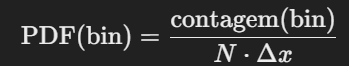

In [44]:
SAVE = False


In [45]:
printa_duration = False
list_duration = []

for ANO in range(ANOi_esc,ANOf_esc+1):

    for S_ID in IDs_dict[ANO]:
        storm_data = storm_data_final_years[ANO][storm_data_final_years[ANO]['ID'] == S_ID]

        duration = round(len(storm_data['Time'])/24 , 2)

        list_duration.append(duration)

        if printa_duration:
            print('Cyclone '+str(S_ID)+' duration in the region (days):',duration)
            print(storm_data['Time'].iloc[0],' till ',
                 storm_data['Time'].iloc[-1])
            print()

    print(len(list_duration))
    
list_duration.sort()


51
113


In [46]:
values_xaxis = list_duration 
range_xaxis=(0,8)
pdf, ocorrencias_cada_bin, bin_edges, bin_width = rm.calcula_pdf(values_xaxis = values_xaxis,
                                                              numero_de_bins = 16,range_xaxis=range_xaxis)

Soma da PDF (verificação de normalização): 0.8407079646017699, deve ser igual a 1. Se nao, é porque alguns dados em values_xaxis caem fora do intervalo range_xaxis fornecido (eles não serão considerados no cálculo). Isso reduziria a soma da PDF.


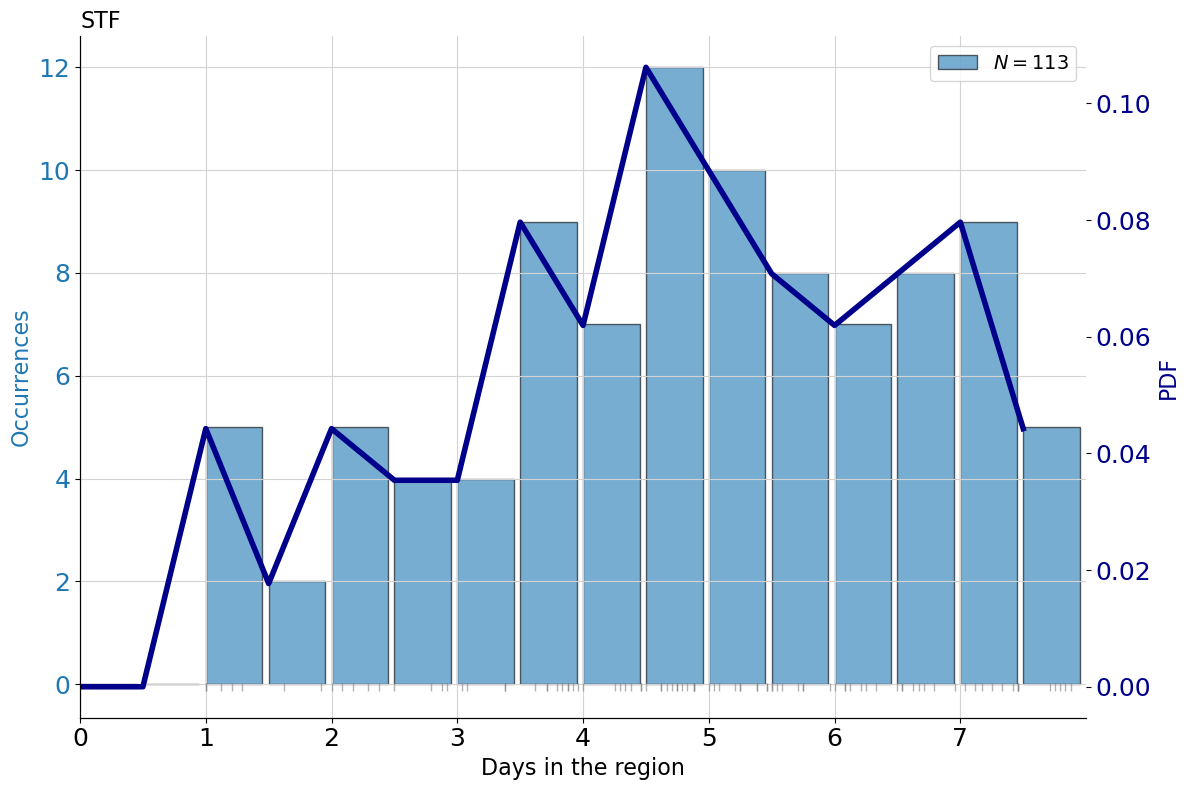

In [47]:
# Criar a figura e os eixos
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotar o histograma com transparência e cor diferenciada
ax1.bar(
    bin_edges[:-1],
    ocorrencias_cada_bin,
    width=bin_width*0.9,
    color="tab:blue",
    edgecolor="black",
    alpha=0.6,
    align="edge",
    label=f"$N={len(list_duration)}$")

# Eixo Y para ocorrências
ax1.set_xlabel("Days in the region", fontsize=16)
ax1.set_ylabel("Occurrences", fontsize=16, color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="best", fontsize=14)

## Criar o segundo eixo para a PDF e plotar a curva
ax2 = ax1.twinx()
ax2.plot(bin_edges[:-1], pdf * bin_width, color="darkblue", lw=4, label="PDF")
ax2.set_ylabel("PDF", fontsize=16, color="darkblue")
ax2.tick_params(axis="y", labelcolor="darkblue")

##ax2.spines['right'].set_visible(True)  # Mantém a linha vertical do eixo y2
ax2.yaxis.set_ticks_position('right')  # Garante que os ticks estejam à direita
ax2.grid(False)  # Remove as linhas da grade


## Adicionar rug plots (traços para representar dados individuais)
ax1.plot(values_xaxis, [-0.05] * len(values_xaxis), '|', color='gray', alpha=0.6, label="Data points")

## Adicionar título e ajustar ticks
plt.xticks(np.arange(0, 8), fontsize=14, rotation=45)
plt.xlim(list(range_xaxis))
plt.title(zone.upper(),loc='left',fontsize=16)

# Ajustar o layout e mostrar o gráfico
fig.tight_layout()
plt.show()


if SAVE:
    fig.savefig(dirfigsCFSR+'Estatistica/Cond'+str(CONDICAO)+'_'+zone+'_Duration_'+name+'_'+str(ANOi)+'a'+str(ANOf)+'.jpeg',bbox_inches='tight')


In [48]:
list_vortmax = []
list_vortmin = []
list_vortmean = []

for ANO in range(ANOi_esc,ANOf_esc+1):
    print(ANO)
    for S_ID in IDs_dict[ANO]:
        try:
            storm_data = storm_data_final_years[ANO][storm_data_final_years[ANO]['ID'] == S_ID]

            vortmax = round(np.nanmax(storm_data['T42 vorticity']),2)
            vortmin = round(np.nanmin(storm_data['T42 vorticity']),2)
            vortmean = round(np.nanmean(storm_data['T42 vorticity']),2)

            list_vortmax.append(vortmax)
            list_vortmin.append(vortmin)
            list_vortmean.append(vortmean)

        except Exception as e:
            print(e)



    print(len(list_vortmax))
    
list_vortmax.sort()
list_vortmin.sort()
list_vortmean.sort()


2001
51
2002
113


In [49]:
values_xaxis = list_vortmax 
range_xaxis=(0,10)
pdf, ocorrencias_cada_bin, bin_edges, bin_width = rm.calcula_pdf(values_xaxis = values_xaxis,
                                                              numero_de_bins = 20,range_xaxis=range_xaxis)

Soma da PDF (verificação de normalização): 0.6106194690265487, deve ser igual a 1. Se nao, é porque alguns dados em values_xaxis caem fora do intervalo range_xaxis fornecido (eles não serão considerados no cálculo). Isso reduziria a soma da PDF.


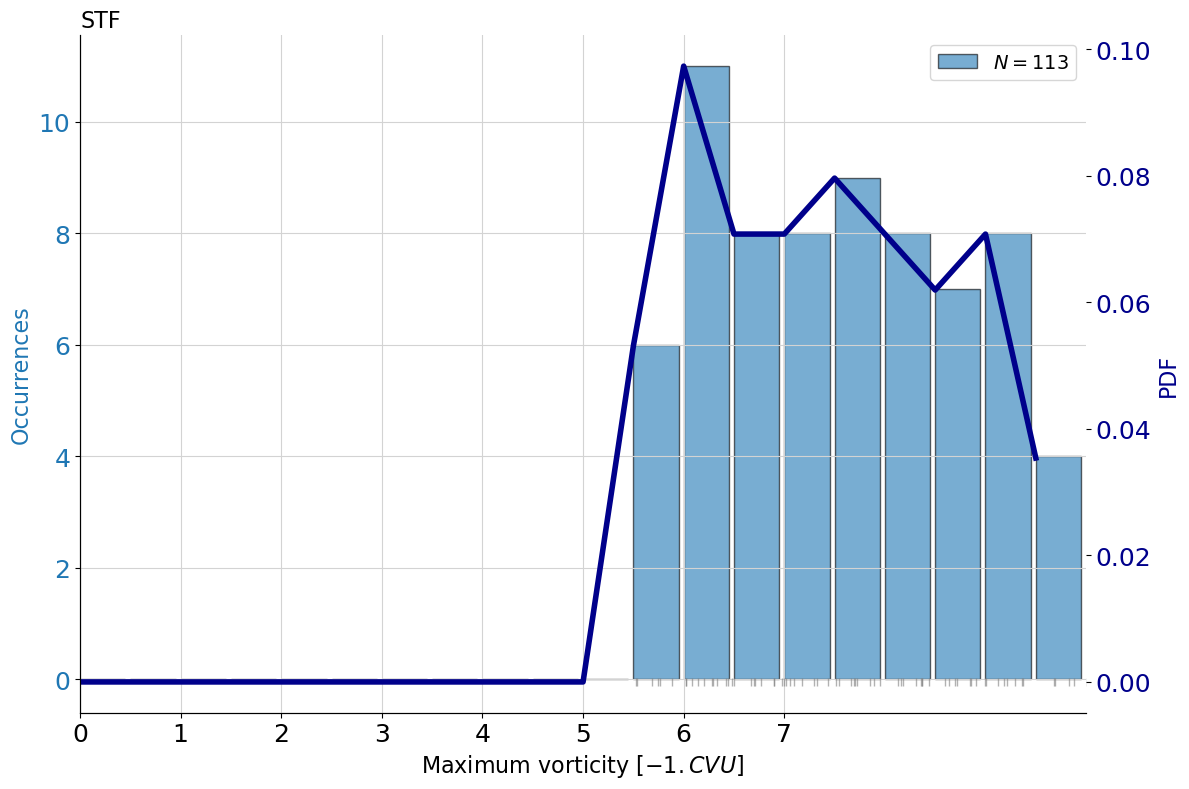

In [50]:


# Criar a figura e os eixos
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotar o histograma com transparência e cor diferenciada
ax1.bar(
    bin_edges[:-1],
    ocorrencias_cada_bin,
    width=bin_width*0.9,
    color="tab:blue",
    edgecolor="black",
    alpha=0.6,
    align="edge",
    label=f"$N={len(list_vortmax)}$",
)

# Eixo Y para ocorrências
ax1.set_xlabel("Maximum vorticity [$-1 . CVU$]", fontsize=16)
ax1.set_ylabel("Occurrences", fontsize=16, color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="best", fontsize=14)

## Criar o segundo eixo para a PDF e plotar a curva
ax2 = ax1.twinx()
ax2.plot(bin_edges[:-1], pdf * bin_width, color="darkblue", lw=4, label="PDF")
ax2.set_ylabel("PDF", fontsize=16, color="darkblue")
ax2.tick_params(axis="y", labelcolor="darkblue")
#
##ax2.spines['right'].set_visible(True)  # Mantém a linha vertical do eixo y2
ax2.yaxis.set_ticks_position('right')  # Garante que os ticks estejam à direita
ax2.grid(False)  # Remove as linhas da grade


## Adicionar rug plots (traços para representar dados individuais)
ax1.plot(values_xaxis, [-0.05] * len(values_xaxis), '|', color='gray', alpha=0.6, label="Data points")

## Adicionar título e ajustar ticks
plt.xticks(np.arange(0, 8), fontsize=14, rotation=45)
#plt.yticks(fontsize=14)
plt.xlim(list(range_xaxis))
plt.title(zone.upper(),loc='left',fontsize=16)

# Ajustar o layout e mostrar o gráfico
fig.tight_layout()
plt.show()



if SAVE:
    fig.savefig(dirfigsCFSR+'Estatistica/Cond'+str(CONDICAO)+'_'+zone+'_MaxVort_'+name+'_'+str(ANOi)+'a'+str(ANOf)+'.jpeg',bbox_inches='tight')

In [51]:
printa_duration = False
f_ID = None
list_duration_to_max = []

for ANO in range(ANOi_esc,ANOf_esc+1):

    for S_ID in IDs_dict[ANO][:f_ID]:

        try:
            storm_data = storm_data_final_years[ANO][storm_data_final_years[ANO]['ID'] == S_ID]

            newTime = np.linspace(0,1,len(storm_data))

            where = np.where(storm_data['T42 vorticity'] == np.nanmax(storm_data['T42 vorticity']))[0][0]


            if printa_duration:


                plt.figure()
                plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.turbo(np.linspace(0.2,1, len(IDs[:f_ID])))))

                plot1, = plt.plot(newTime,
                             (((storm_data['T42 vorticity'] - np.nanmean((storm_data['T42 vorticity'])) ))/np.nanstd(storm_data['T42 vorticity'])),
                         lw=2,alpha=0.8,marker='o',markersize=3)
                plt.plot(newTime[where],
                         np.nanmax(((storm_data['T42 vorticity'] - np.nanmean((storm_data['T42 vorticity'])) ))/np.nanstd(storm_data['T42 vorticity'])),
                         ls='',marker='o',markersize=10,color=plot1.get_color())

                print('np.shape(newTime):',np.shape(newTime))
                print('where is max: ', (where))
                print('-----')

            where = round(where/24,2)

            list_duration_to_max.append(where)
        except Exception as e:
            print(e)        

    
list_duration_to_max.sort()
print(len(list_duration_to_max))

113


In [52]:
values_xaxis = list_duration_to_max 
range_xaxis=(0,8)
pdf, ocorrencias_cada_bin, bin_edges, bin_width = rm.calcula_pdf(values_xaxis = values_xaxis,
                                                              numero_de_bins = 16,range_xaxis=range_xaxis)

Soma da PDF (verificação de normalização): 0.9823008849557522, deve ser igual a 1. Se nao, é porque alguns dados em values_xaxis caem fora do intervalo range_xaxis fornecido (eles não serão considerados no cálculo). Isso reduziria a soma da PDF.


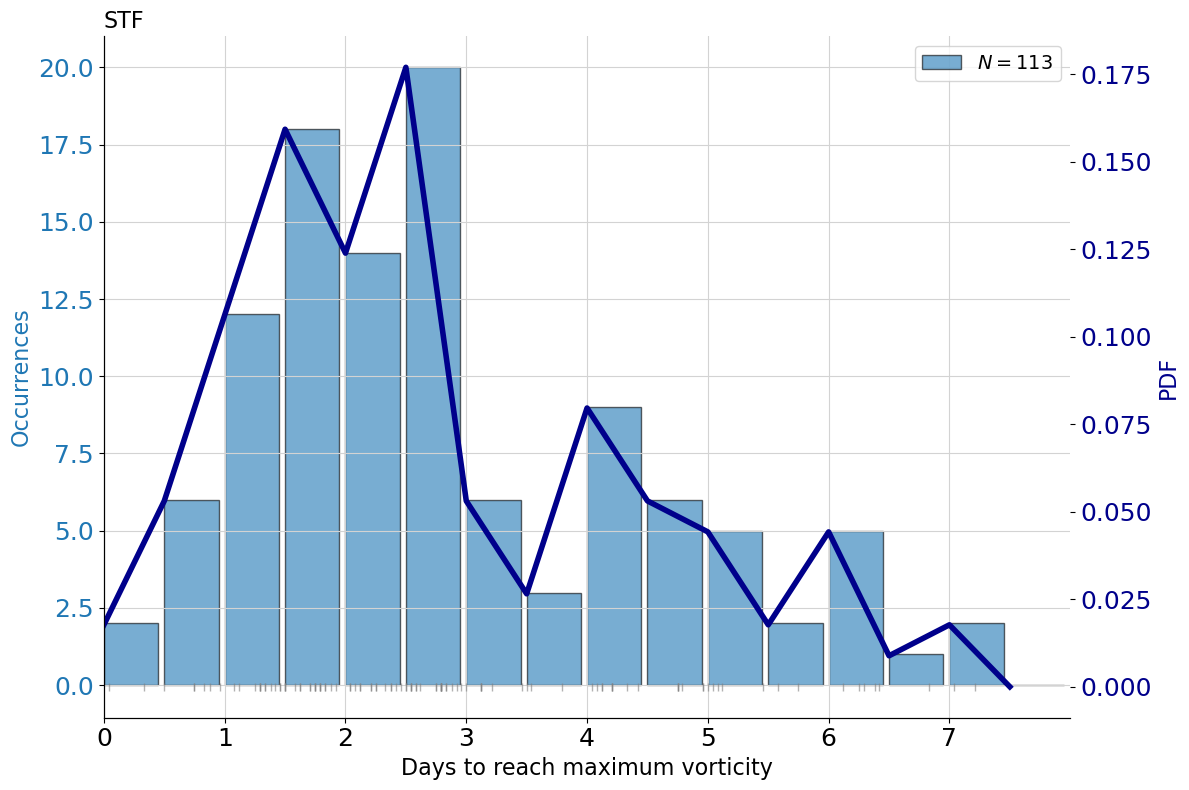

In [53]:
# Criar a figura e os eixos
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotar o histograma com transparência e cor diferenciada
ax1.bar(
    bin_edges[:-1],
    ocorrencias_cada_bin,
    width=bin_width*0.9,
    color="tab:blue",
    edgecolor="black",
    alpha=0.6,
    align="edge",
    label=f"$N={len(list_duration_to_max)}$")

# Eixo Y para ocorrências
ax1.set_xlabel("Days to reach maximum vorticity", fontsize=16)
ax1.set_ylabel("Occurrences", fontsize=16, color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="best", fontsize=14)

## Criar o segundo eixo para a PDF e plotar a curva
ax2 = ax1.twinx()
ax2.plot(bin_edges[:-1], pdf * bin_width, color="darkblue", lw=4, label="PDF")
ax2.set_ylabel("PDF", fontsize=16, color="darkblue")
ax2.tick_params(axis="y", labelcolor="darkblue")

##ax2.spines['right'].set_visible(True)  # Mantém a linha vertical do eixo y2
ax2.yaxis.set_ticks_position('right')  # Garante que os ticks estejam à direita
ax2.grid(False)  # Remove as linhas da grade


## Adicionar rug plots (traços para representar dados individuais)
ax1.plot(values_xaxis, [-0.05] * len(values_xaxis), '|', color='gray', alpha=0.6, label="Data points")

## Adicionar título e ajustar ticks
plt.xticks(np.arange(0, 8), fontsize=14, rotation=45)
plt.xlim(list(range_xaxis))
plt.title(zone.upper(),loc='left',fontsize=16)

# Ajustar o layout e mostrar o gráfico
fig.tight_layout()
plt.show()



if SAVE:
    fig.savefig(dirfigsCFSR+'Estatistica/Cond'+str(CONDICAO)+'_'+zone+'_DurationToMax_'+name+'_'+str(ANOi)+'a'+str(ANOf)+'.jpeg',bbox_inches='tight')

# TIME NORMALIZATION PROCEDURE:

8
28
42
44
49
Novo eixo x: [0.   0.25 0.5  0.75 1.  ]
len(Novo eixo x): 5


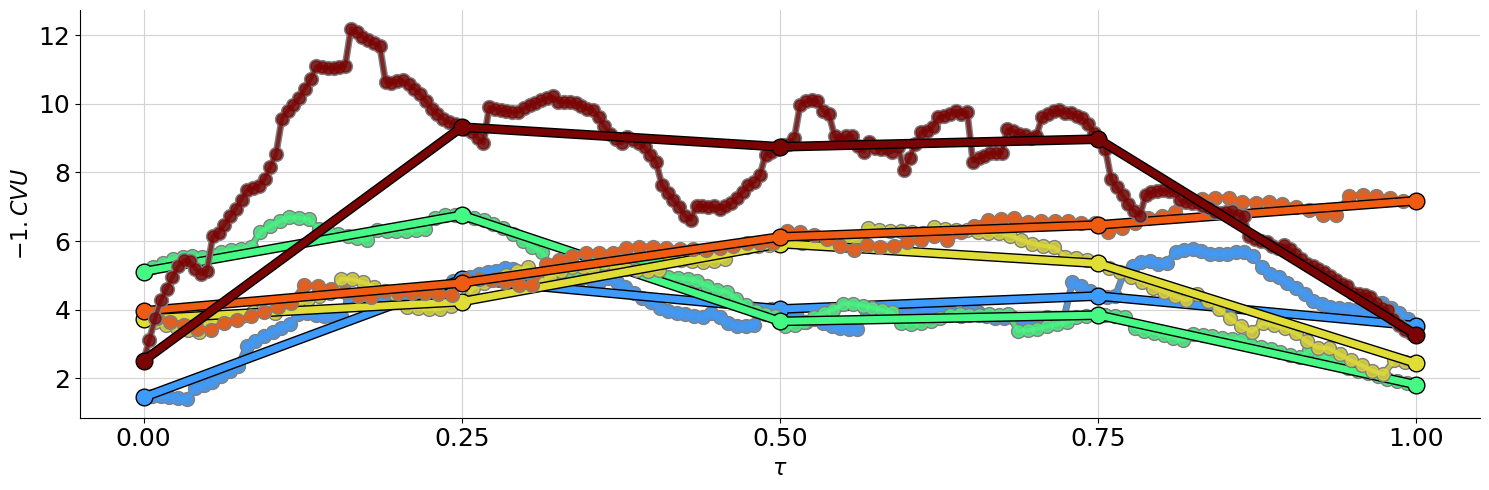

In [54]:
f_ID=5

plt.figure()
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.turbo(np.linspace(0.2,1, len(IDs[:f_ID])))))
new_len = 5

for S_ID in IDs_dict[ANO][:5]:
    #IDs_esc = list(dict_pol[ANO][zone][original_ou_hp][VAR][CLAS].keys())
    try:
        print(S_ID)
        newTime = np.linspace(0,1,len(storm_data_final_years[ANO][storm_data_final_years[ANO]['ID'] == S_ID]))
        plt.plot(newTime,(storm_data_final_years[ANO][storm_data_final_years[ANO]['ID'] == S_ID]['T42 vorticity']),
                 lw=5,alpha=1,color='grey',marker='o',markersize=10)
        plot1, = plt.plot(newTime,(storm_data_final_years[ANO][storm_data_final_years[ANO]['ID'] == S_ID]['T42 vorticity']),
                 lw=3,alpha=0.7,marker='o',markersize=8)#,label=S_ID)

        #NORMALIZING
        data_original = (storm_data_final_years[ANO][storm_data_final_years[ANO]['ID'] == S_ID]['T42 vorticity'])
        data_interpolada,x_new = rm.interpolate_to_new_len(data_original,new_len = new_len,interp_kind = 'linear')
        plt.plot(x_new,data_interpolada,lw=7,marker='o',markersize=12, color = 'k')#,label=S_ID)
        plt.plot(x_new,data_interpolada,lw=5,marker='o',markersize=10, color = plot1.get_color())#,label=S_ID)
        plt.xticks([0,0.25,0.50,0.75,1])
        plt.xlabel(r"$\tau$", fontsize=16)
        plt.ylabel("$-1 . CVU$", fontsize=16)

        
    except Exception as e:
        print(e)


    
#plt.title('Normalizando e interpolando a vorticidade para '+str(new_len)+' time steps\n'+
#           '(tau = 0, '+str((1/new_len))+', '+str((2/new_len))+', ...,'+str(new_len/new_len)+')')
print('Novo eixo x:',x_new)
print('len(Novo eixo x):',len(x_new))





Wood et al 2023


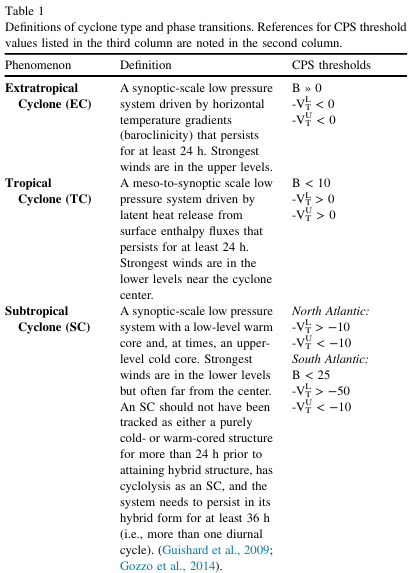

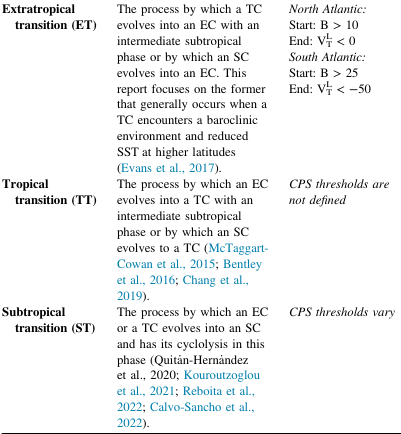

Simetrico (Nonfrontal): -10 < B < 10

Assimetrico (Frontal): B > 10

Cold core: $-V_T^L$ < 0, $-V_T^U$ < 0 

Warm core: $-V_T^L$ > 0, $-V_T^U$ > 0 



___

**ETC:** Classico

<span style="color:red;">$B > 10$</span>; <span style="color:blue;">$-V_T^L < 0$</span>; <span style="color:green;">$-V_T^U < 0$</span>

**TC:**

<span style="color:orange;">$-10 < B < 10$</span>; <span style="color:purple;">$-V_T^L > 0$</span>; <span style="color:teal;">$-V_T^U > 0$</span>

**STC:**

<span style="color:maroon;">$-10 < B < 25$</span>; <span style="color:olive;">$-V_T^L > -50$</span>; <span style="color:navy;">$-V_T^U < -10$</span> (Gozzo et al 2014, Wood et al 2023)

**ET:**

Start: <span style="color:red;">$B > 25$</span>; ; End: <span style="color:blue;">$-V_T^L < -50$</span>


In [55]:
dict_cps = {}
dict_pol = {}


In [56]:
i_ID = 0
f_ID = 40 #None #USE None HERE TO GET ALL THE SELECTED CYCLONES. I USE 40 JUST TO REPRESENT JUST THE FIRST 40 CYCLONES AS EXAMPLE

original_ou_hp = 'original'

max_dist_ocn = 1000

ref_ocean = 2*8 #2 DIAS * 8 POR E RESOLUCAO DE 3H
ref_ocean = 2*8 #5 DIAS * 8 POR E RESOLUCAO DE 3H
without_refocean = False

#FOR POLAR PROJECTION PLOT:
# Create a regular grid in polar coordinates
radii = np.linspace(0,1000,101)#np.nanmin(radius), np.nanmax(radius), 100)#np.linspace(min(radius), max(radius), 100)
thetas = np.radians(np.linspace(0, 360, 37))#np.linspace(0, 2 * np.pi, 37)

r_grid, theta_grid = np.meshgrid(radii, thetas)
## Convert grid to Cartesian for interpolation
x_grid = r_grid * np.cos(theta_grid) #x = r.cos(theta)
y_grid = r_grid * np.sin(theta_grid) #y = r.sen(theta)

levels_ang=np.arange(0,370,10)

'''----------------ATTENTION! THE FIRST NEEDS TO BE slp TO EVALUATE THE BOMB CYCLONES----------------'''
VARS=['slp','lh_surf','sst']
'''----------------ATTENTION! THE FIRST NEEDS TO BE slp TO EVALUATE THE BOMB CYCLONES----------------'''

x,y = np.meshgrid(dict_CFS['lon_atm'],dict_CFS['lat_atm'])
land = global_land_mask.is_land(lat=y,lon=x)

# CALCULATING THE CYCLONE PHASE SPACE PARAMETERS (dict_cps) AND TRANSFORMING THE VARIABLES TO POLAR COORDINATES (dict_pol), AND IDENTIFYING THE BOMB CYCLONES

In [ ]:

plota_figure_1 = False
plota_figure_1_polar = False

plota_figure_2 = False
plota_figure_2_polar = False

save = False
SAVE_FIG2 = False
SAVE_FIG2_POL = False


storm_data_final_new_allyears = {}
bugs = []

for ANO in range(ANOi_esc,ANOf_esc+1):
    print(ANO,ANO,ANO,ANO,ANO,ANO,ANO)
    
    dict_cps[ANO] = {};                   dict_pol[ANO] = {}
    dict_cps[ANO][zone] = {};             dict_pol[ANO][zone] = {}
    dict_cps[ANO][zone]['original'] = {}; dict_pol[ANO][zone]['original'] = {}
    dict_cps[ANO][zone]['hp'] = {};       dict_pol[ANO][zone]['hp'] = {}    
    
    
    IDs_esc = IDs_dict[ANO][i_ID:f_ID] #<------------------------------------

    '''--------------------ATTENTION! THE FIRST NEEDS TO BE slp TO EVALUATE THE BOMB CYCLONES--------------------'''
    for VAR in VARS[:]:
        '''----------------ATTENTION! THE FIRST NEEDS TO BE slp TO EVALUATE THE BOMB CYCLONES----------------'''
        print(VAR)
        dict_cps[ANO][zone][original_ou_hp][VAR] = {};   dict_pol[ANO][zone][original_ou_hp][VAR] = {}
        dict_cps[ANO][zone][original_ou_hp][VAR]['unclass'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['unclass'] = {}
        dict_cps[ANO][zone][original_ou_hp][VAR]['F'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['F'] = {} #FRONTAL O TEMPO TODO
        dict_cps[ANO][zone][original_ou_hp][VAR]['NF'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['NF'] = {} #NÃO-FRONTAL O TEMPO TODO
        dict_cps[ANO][zone][original_ou_hp][VAR]['LCC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['LCC'] = {} #FRONTAL O TEMPO TODO
        dict_cps[ANO][zone][original_ou_hp][VAR]['LWC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['LWC'] = {} #NÃO-FRONTAL O TEMPO TODO
        #More complexity:
        dict_cps[ANO][zone][original_ou_hp][VAR]['EC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['EC'] = {} #EXTRATROPICAL: FC -> FC
        dict_cps[ANO][zone][original_ou_hp][VAR]['TC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['TC'] = {} #TROPICAL: NFW->NFW
        #Moments:
        dict_cps[ANO][zone][original_ou_hp][VAR]['NFWC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['NFWC'] = {} 
        dict_cps[ANO][zone][original_ou_hp][VAR]['FCC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['FCC'] = {} 
        dict_cps[ANO][zone][original_ou_hp][VAR]['NFCC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['NFCC'] = {} 
        #BOMB:
        dict_cps[ANO][zone][original_ou_hp][VAR]['BOMB'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['BOMB'] = {} #TROPICAL: NFW->NFW
        dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBF'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBF'] = {} #FRONTAL O TEMPO TODO
        dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBNF'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBNF'] = {} #NÃO-FRONTAL O TEMPO TODO
        dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBLCC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBLCC'] = {} #FRONTAL O TEMPO TODO
        dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBLWC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBLWC'] = {} #NÃO-FRONTAL O TEMPO TODO
        dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBEC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBEC'] = {} #EXTRATROPICAL: FC -> FC
        dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBTC'] = {};   dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBTC'] = {} #TROPICAL: NFW->NFW
        
        
        GPH = dict_CFS[str(ANOi)]['original']['gph']

        lon1 = dict_CFS['lon_atm']
        lat1 = dict_CFS['lat_atm']

        if VAR in ['wnd','wnd_grad']:
            isobar = np.where(dict_CFS['isobaric'] == 850)[0][0]
            var2 = dict_CFS[str(ANOi)][original_ou_hp][VAR][:,isobar,:,:]   
            
            
        else:
            var2 = dict_CFS[str(ANOi)][original_ou_hp][VAR]

        
        '''ATENCAO VER SE AS VARIAVEIS OCEANICAS DA VARS ESTAO AQUI, OU IRÁ INTERROMPER O CODIGO!'''
        if VAR in ['sst']:
            lon2 = dict_CFS['lon_ocn']  
            lat2 = dict_CFS['lat_ocn'] 
        else: 
            lon2 = lon1
            lat2 = lat1
            
            #PUTTING NAN IN THE LAND COORDINATES
            atmmask=np.zeros(shape = np.shape(var2))
            atmmask[:,:,:] = land*100000
            var2[npw(atmmask==100000)] = np.nan

        storm_data_final_new_allyears[ANO] = DF() #NECESSARY FOR THE PLOT OF THE TIME SERIES

        if VAR == 'sst':
            dz_levels = np.linspace(-1,1,11)
            cmap=rm.turbo_com_branco()

        if VAR in ['lh_surf']:
            dz_levels = np.linspace(np.nanmean(var2) - 1*np.nanstd(var2),
                                    np.nanmean(var2) + 1*np.nanstd(var2),20).round(1)            
            cmap=rm.azul_e_fogo_claro()
 
            
        if VAR == 'slp':
            dz_levels = np.linspace(np.nanmean(var2) - 1.5*np.nanstd(var2),
                                    np.nanmean(var2) + 1.5*np.nanstd(var2),20).round()
            cmap='twilight_shifted'

                
        
        for S_ID in IDs_esc:

            print('Storm ID:',S_ID)
            
            try:
                (thickness,storm_lats,storm_lons,max_dist,
                 TEMPO_INI,liste_time,idate,listlev1,listlev2,
                 lev,cicl_esc) = cps.parametros_CPS(GPH = GPH,
                                                    isobaric = dict_CFS['isobaric'],
                                                    time_field     = dict_CFS[str(ANOi)]['time_atm'],
                                                    camargo  = storm_data_final_in_region_years[ANO],
                                                    STORM_ID_ESC = S_ID, 
                                                    cps_or_radiuscomp = 'cps',
                                                    print_check=False)

                '''CALCULO DO PARAMETRO B'''
                B_series=[]
                B2_series=[]
                SLP_series = []
                VARr_mean_series=[]
                VARl_mean_series=[]
                VARr_std_series=[]
                VARl_std_series=[]
                velo_series=[]


                data_thick_pol_list = []


                data_var2_pol_list = []

                ang_list = []
                qq_ang_all_list = []
                #INICIANDO LOOP DO VARIAVEL DO CAMPO NOS INDICES DA S_ID (INICIO COINCIDE NO INDEX TEMPO_INI)
                '''ATENCAO: ESSE if PARA PEGAR OS QUE FICAM AO MENOS 12h NAO RESTRINGE À HORAS CONSECUTIVAS. 
                ALGUNS POSSUEM UM SALTO E ISSO DANIFICA O CALCULO DA VELOCIDADE DE PROPAGAÇÃO'''
                if len(liste_time)>4: #PARA PEGAR APENAS OS QUE FICAM PELO MENOS 12h NA REGIAO
                    for i in tqdm(range((TEMPO_INI),(TEMPO_INI)+len(liste_time) -1)): #THE -1 IS NEEDED DUE TO THE LAST STEP AT THE CALCULUS OF THE ANGLE: storm_lons[i-TEMPO_INI+1]
                        #print('i:',i)
                        data_thick = thickness[i,:,:]#[0,:,:] #(2920, 56, 64)

                        if original_ou_hp == 'original':
                            data_var2 = var2[i,:,:] - var2[i-ref_ocean,:,:] #DIA DE REFERENCIA
                        else:
                            data_var2 = var2[i,:,:]
                            
                        if without_refocean:
                            data_var2 = var2[i,:,:]

                        if VAR in ['slp','slp_grad','wnd','wnd_grad','vor_grad','ast_grad']:
                            data_var2 = var2[i,:,:] #CADA i EQUIVALE A 1 PASSO, DE 3h 

                        # STORM CENTER coordinates
                        storm_lat_i = storm_lats[i-TEMPO_INI]
                        storm_lon_i = storm_lons[i-TEMPO_INI]

                        # Calculate bearing between storm center and all other lat/lon pairs
                        qq_ang_all=np.zeros([len(lon1),len(lat1)],dtype='f')

                        for x in range(0,len(lon1)):
                            for y in range(0,len(lat1)):
                                qq_ang_all[x,y]= cps.get_bearing(storm_lat_i, storm_lon_i, lat1[y], lon1[x])
                                #AQUI ESTÁ CALCULANDO O AZIMUTE ENTRE O TRACK E TODOS OS OUTROS PONTOS DE LAT LON DO MAPA, EM CADA PASSO DO CICLONE


                        qq_ang_all = np.transpose(qq_ang_all)
                        theta_radians = np.radians(qq_ang_all)

                        max_ahead = min(8, len(storm_lats) - (i - TEMPO_INI) - 1)  # para determinar o número máximo de passos possíveis sem ultrapassar o limite do array

                        angs_next_steps = []

                        for ahead in range(1, max_ahead + 1):  # Calcular o ângulo para cada um dos próximos passos disponíveis (até no máximo ahead = 5)

                            ang = cps.get_bearing(storm_lat_i, storm_lon_i, storm_lats[i - TEMPO_INI + ahead], 
                                                  storm_lons[i - TEMPO_INI + ahead])
                            angs_next_steps.append(ang)

                        ang = np.nanmean(angs_next_steps)

                        # Define right/left cadrans
                        Zl = np.zeros([len(lat1),len(lon1)],dtype='f')
                        Zr = np.zeros([len(lat1),len(lon1)],dtype='f')


                        for jlat in range(0,len(lat1)-1):
                            for jlon in range(0,len(lon1)-1):
                                #set values along great circle line to missing (neither left nor right)
                                if qq_ang_all[jlat,jlon] == ang:
                                    Zl[jlat,jlon] = np.nan
                                    Zr[jlat,jlon] = np.nan


                                #for storm travel angles in quadrants 1 and 2 (NE and SE)
                                elif (ang >= 0 and ang < 180):
                                    if (qq_ang_all[jlat,jlon] > ang and qq_ang_all[jlat,jlon]  < ang+180):
                                        Zl[jlat,jlon] = np.nan
                                        Zr[jlat,jlon] = data_thick[jlat,jlon]

                                    else:
                                        Zl[jlat,jlon] = data_thick[jlat,jlon]
                                        Zr[jlat,jlon] = np.nan

                                #for storm travel angles in quadrants 3 and 4 (NW and SW)
                                elif (ang >= 180 and ang < 360):
                                    if (qq_ang_all[jlat,jlon] > ang-180 and qq_ang_all[jlat,jlon] < ang):
                                        Zr[jlat,jlon] = np.nan
                                        Zl[jlat,jlon] = data_thick[jlat,jlon]

                                    else:
                                        Zr[jlat,jlon] = data_thick[jlat,jlon]
                                        Zl[jlat,jlon] = np.nan

                        displacement = cps.haversine(storm_lat_i, storm_lon_i, storm_lats[i-TEMPO_INI+1], 
                                                     storm_lons[i-TEMPO_INI+1])
                        velo = ((displacement/3)).round() #km/h, pois meu dado tem 3h
                        velo_series.append(velo)

                        #CALCULATING DISTANCE BETWEEN STORM CENTER AND ALL OTHER LAT LON POINTS
                        distance = cps.haversine(lon1[:,np.newaxis], lat1, storm_lon_i, storm_lat_i)
                        distance = np.transpose(distance)

                        DISTANCIA = distance
                        DISTANCIA_m = np.ma.masked_where(DISTANCIA > max_dist, DISTANCIA) #MASCARA NA MATRIZ DE DISTANCIA TBM

                        # Mask distance array where distance > max_dist
                        distance_m = np.ma.masked_greater(distance, max_dist)

                        # Mask the data array based on the distance mask
                        data_thick_m = np.ma.masked_where(distance > max_dist, data_thick)

                        Zr_m = np.ma.masked_where(distance > max_dist, Zr)
                        Zl_m = np.ma.masked_where(distance > max_dist, Zl)

                        #HERE WE CALCULATE THE AVERAGE IN THE LEFT AND RIGHT BRANCHES
                        # cyclone thermal symmetry parameter using weighted average
                        Zr_mean=np.nanmean(Zr_m)
                        Zl_mean=np.nanmean(Zl_m)

                        B = Zr_mean-Zl_mean             #FIM DO CALCULO DO PARAMETRO B:

                        if storm_lat_i < 0: #HART 2003:  The integer h takes a value of 1 for the Northern Hemisphere and 1 for the Southern Hemisphere.
                            B = -B

                        B_series.append(B)

                        #----------------------------------- INTERPOLATION FOR A POLAR GRID
                        rotatednorth = ((qq_ang_all-ang)+360) % 360

                        radius = DISTANCIA   # Radius values
                        angle = np.radians(rotatednorth)   # Angle values in radians

                        ## Interpolate in polar coordinates (using Cartesian transformation)
                        data_thick_pol = griddata(
                                            ( (radius * np.cos(angle)).ravel(), (radius * np.sin(angle)).ravel() ), #(radius * np.cos(angle), radius * np.sin(angle)),  # Convert original data to Cartesian
                                            data_thick.ravel(),#temperature,
                                            (x_grid, y_grid),  # Regular Cartesian grid
                                            method='linear'  # 'linear', 'nearest', or 'cubic'
                                                )
                        data_thick_pol_list.append(data_thick_pol)


                        #---------------------PLOTTING THE FIGURE
                        if plota_figure_1:
                            th_dz_levels = np.linspace(np.nanmean(thickness) - 2*np.nanstd(thickness),
                                                    np.nanmean(thickness) + 2*np.nanstd(thickness),40)
                            cmap='twilight_shifted'

                            fig = plt.figure(figsize=(12, 9))
                            ax = fig.add_subplot(1, 1, 1, projection=projecao)
                            fig.suptitle('Storm '+str(S_ID)+', low level thickness and right/left quadrants',fontsize=16)
                            ax.set_title(liste_time[i-TEMPO_INI-1]+' : B = '+str(int(B)),fontsize=14)
                            cps.plot_background(ax)
                            ax.set_extent(*cps.bounds(), crs=ccrs.PlateCarree())

                            #BACKGROUND------------
                            cf_background = ax.contourf(lon1, lat1, data_thick, levels=th_dz_levels,
                                             cmap=cmap, alpha=0.5, transform=ccrs.PlateCarree())
                            cb_background = fig.colorbar(cf_background, orientation='vertical', aspect=30, shrink=0.7, pad=0.02)
                            cb_background.set_label('m')

                            c_background = ax.contour(lon1, lat1, data_thick, levels=th_dz_levels,
                                            colors="black", linewidths=0.9,alpha=0.8, transform=ccrs.PlateCarree())
                            ax.clabel(c_background,fmt='%4.1i',fontsize=10,levels=th_dz_levels[::2])

                            #CYCLONE RADIUS----------
                            c0 = ax.contour(lon1, lat1, data_thick_m, levels=th_dz_levels,
                                            colors="black", linewidths=1, transform=ccrs.PlateCarree())
                            ax.clabel(c0,fmt='%4.1i',fontsize=10,levels=th_dz_levels[::2])


                            cf1 = ax.contourf(lon1, lat1, Zr_m, th_dz_levels,
                                             cmap=cmap, transform=ccrs.PlateCarree())

                            cf2 = ax.contourf(lon1, lat1, Zl_m, th_dz_levels,
                                             cmap=cmap, transform=ccrs.PlateCarree())

                            cb1 = fig.colorbar(cf1, orientation='horizontal', aspect=50, shrink=0.6, pad=0.03)
                            cb1.set_label('m')
                            cb1.ax.tick_params(labelrotation=45)   

                            c3 = ax.contour(lon1, lat1, rotatednorth, levels_ang,
                                            colors="grey", linewidths=0.5, alpha=0.8, transform=ccrs.PlateCarree())
                            ax.clabel(c3,fmt='%4.1i',fontsize=10)

                            # PLOTANDO O TRACK 
                            plt.plot(cicl_esc['Longitude'], cicl_esc['Latitude'], color='w',marker='X',markersize=4,lw=4,alpha=0.7)
                            plt.plot(cicl_esc['Longitude'], cicl_esc['Latitude'], color='w',marker='X',markersize=2,lw=2)

                            plt.plot(cicl_esc['Longitude'].iloc[i-TEMPO_INI],cicl_esc['Latitude'].iloc[i-TEMPO_INI],
                                     'X',
                                     color='k',markersize=8, markeredgecolor='w')

                            plt.plot(cicl_esc['Longitude'].iloc[0], cicl_esc['Latitude'].iloc[0], 'o', 
                                     color='k',markersize=8, markeredgecolor='w')
                            plt.plot(cicl_esc['Longitude'].iloc[-1], cicl_esc['Latitude'].iloc[-1], 'd', 
                                     color='k',markersize=8, markeredgecolor='w')

                            #plt.show()

                            if save:
                                try:
                                    rm.cria_diretorio(folder_path_withbar=dirfigsCFSR+'CPS_tests/',
                                                      folder_name_withoutbars='Track_'+str(S_ID)+'_Thermal_symmetry_'+str(ANO))
                                except:
                                    pass
                                figname=dirfigsCFSR+'CPS_tests/'+'Track_'+str(S_ID)+'_Thermal_symmetry_'+str(ANO)+'/Thermal_symmetry_'+liste_time[i-TEMPO_INI]
                                fig.savefig(figname+'.jpeg',bbox_inches='tight')
                            #plt.close()

                        #POLAR PROJECTION ----------------------------------------------------------------------    
                        if plota_figure_1_polar:

                            th_dz_levels = np.linspace(np.nanmean(thickness) - 2*np.nanstd(thickness),
                                                    np.nanmean(thickness) + 2*np.nanstd(thickness),40)
                            cmap='twilight_shifted'

                            ## Plot in polar coordinates
                            fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
                            c = ax.contourf(theta_grid, r_grid, data_thick_pol, cmap=cmap,levels=th_dz_levels,extend='both')
                            fig.colorbar(c, label='Variable')

                            # ---- mod here ---- #
                            ax.set_theta_zero_location("N")  # theta=0 at the top
                            ax.set_theta_direction(-1)  # theta increasing clockwise

                            #plt.ylim(0, 1000)  # Raio até 1000 km

                            plt.title('Interpolated Variable Field in Polar Projection')
                            plt.show()


                        #SECOND VARIABLE HERE: ------------------------------------
                        #------------------------------------CALCULATING FOR THE OCEANIC VARIABLE WHICH HAS DIFFERENT lat AND lon (RES)
                        #REMEMBER: THE OCEANIC VARIABLE WHICH HAS 0.5° RES. 
                        qq_ang_all = np.zeros([len(lon2),len(lat2)],dtype='f')
                        #ang_all = np.zeros([len(lon2),len(lat2)],dtype='f')

                        for x in range(0,len(lon2)):
                            for y in range(0,len(lat2)):
                                qq_ang_all[x,y]= cps.get_bearing(storm_lat_i, storm_lon_i, lat2[y], lon2[x])
                                #ang_all[x,y]= cps.get_bearing(storm_lat_i, storm_lon_i, lat2[y], lon2[x])


                        qq_ang_all = np.transpose(qq_ang_all)
                        theta_radians2 = np.radians(qq_ang_all) #<<<--------------------------------------angle FOR POLAR PROJ

                        # Angle of travel of the center
                        # Enquanto o ângulo for maior que 180, continue aumentando o 'ahead' e recalculando o ângulo
                        angs_next_steps = []

                        for ahead in range(1, max_ahead + 1):  # Calcular o ângulo para cada um dos próximos passos disponíveis (até no máximo ahead = 5)

                            ang = cps.get_bearing(storm_lat_i, storm_lon_i, storm_lats[i - TEMPO_INI + ahead], storm_lons[i - TEMPO_INI + ahead])
                            angs_next_steps.append(ang)
                        ang = np.nanmean(angs_next_steps)

                        # Define right/left cadrans
                        VARl=np.zeros([len(lat2),len(lon2)],dtype='f')
                        VARr=np.zeros([len(lat2),len(lon2)],dtype='f')

                        for jlat in range(0,len(lat2)-1):
                            for jlon in range(0,len(lon2)-1):
                                #set values along great circle line to missing (neither left nor right)
                                if qq_ang_all[jlat,jlon] == ang:

                                    VARl[jlat,jlon] = np.nan
                                    VARr[jlat,jlon] = np.nan

                                #for storm travel angles in quadrants 1 and 2 (NE and SE)
                                elif (ang >= 0 and ang < 180):
                                    if (qq_ang_all[jlat,jlon] > ang and qq_ang_all[jlat,jlon]  < ang+180):
                                        VARl[jlat,jlon] = np.nan
                                        VARr[jlat,jlon] = data_var2[jlat,jlon]

                                    else:

                                        VARl[jlat,jlon] = data_var2[jlat,jlon]
                                        VARr[jlat,jlon] = np.nan

                                #for storm travel angles in quadrants 3 and 4 (NW and SW)
                                elif (ang >= 180 and ang < 360):
                                    if (qq_ang_all[jlat,jlon] > ang-180 and qq_ang_all[jlat,jlon] < ang):
                                        VARr[jlat,jlon] = np.nan
                                        VARl[jlat,jlon] = data_var2[jlat,jlon]

                                    else:
                                        VARr[jlat,jlon] = data_var2[jlat,jlon]
                                        VARl[jlat,jlon] = np.nan 


                        # Calculate distance between center and all other lat/lon pairs
                        distance = cps.haversine(lon2[:,np.newaxis], lat2, storm_lon_i, storm_lat_i)
                        distance = np.transpose(distance)

                        DISTANCIA2 = distance
                        DISTANCIA2_m = np.ma.masked_where(DISTANCIA2 > max_dist_ocn, DISTANCIA2) #MASCARA NA MATRIZ DE DISTANCIA TBM
                        qq_ang_all_m = np.ma.masked_where(DISTANCIA2 > max_dist_ocn, qq_ang_all)

                        # Mask distance array where distance > max_dist_ocn
                        distance_m = np.ma.masked_greater(distance, max_dist_ocn)

                        # Mask the data array based on the distance mask
                        data_var2_m = np.ma.masked_where(distance > max_dist_ocn, data_var2)

                        #BOMB OR NOT?
                        if VAR in ['slp']:
                            lat_near = rm.near(lat1,storm_lat_i)

                            lon_near = rm.near(lon1,storm_lon_i)

                            SLP = data_var2[lat_near,lon_near]
                            SLP_series.append(SLP)

                        #----------------------------------- INTERPOLATION FOR A POLAR GRID
                        rotatednorth = ((qq_ang_all-ang)+360) % 360

                        radius = DISTANCIA2   # Radius values
                        angle = theta_radians2   # Angle values in radians
                        angle = np.radians(rotatednorth)   # Angle values in radians

                        ## Interpolate in polar coordinates (using Cartesian transformation)
                        data_var2_pol = griddata(
                                            ( (radius * np.cos(angle)).ravel(), (radius * np.sin(angle)).ravel() ), # Convert original data to Cartesian
                                            data_var2.ravel(),  #temperature,
                                            (x_grid, y_grid),   # Regular Cartesian grid
                                            method='linear'     # 'linear', 'nearest', or 'cubic'
                                            )
                        data_var2_pol_list.append(data_var2_pol)

                        #---------------------PLOTTING THE FIGURE
                        if plota_figure_2 and VAR != 'slp':


                            fig = plt.figure(figsize=(12, 9))
                            ax = fig.add_subplot(1, 1, 1, projection=projecao)
                            fig.suptitle('Storm '+str(S_ID)+', '+VAR+' right/left quadrants',fontsize=16)
                            ax.set_title(liste_time[i-TEMPO_INI-1]+' : B = '+str(int(B)),fontsize=14)
                            cps.plot_background(ax)
                            ax.set_extent(*cps.bounds(), crs=ccrs.PlateCarree())

                            ##BACKGROUND------------
                            cf_background = ax.contourf(lon2, lat2, data_var2, levels=dz_levels,
                                             cmap=cmap, alpha=0.4, transform=ccrs.PlateCarree(),extend='both')
                            cb_background = fig.colorbar(cf_background, orientation='vertical', aspect=30, 
                                                         shrink=0.7, pad=0.02)

                            c_background = ax.contour(lon2, lat2, data_var2, levels=dz_levels[::2],
                                            colors="w", linewidths=0.8,alpha=0.5, transform=ccrs.PlateCarree())
                            ax.clabel(c_background,fmt='%4.1i',fontsize=10,levels=c_background.levels[::4])

                            #CYCLONE RADIUS----------
                            c0 = ax.contour(lon2, lat2, data_var2_m, levels=dz_levels[::2],
                                            colors="w", linewidths=1, transform=ccrs.PlateCarree())
                            ax.clabel(c0,fmt='%4.1i',fontsize=10,levels=c0.levels[::4])


                            cf1 = ax.contourf(lon2, lat2, VARr_m, dz_levels,
                                             cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
                   

                            cf2 = ax.contourf(lon2, lat2, VARl_m, dz_levels,
                                             cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
                            cb2 = fig.colorbar(cf2, orientation='horizontal', aspect=50, shrink=0.6, pad=0.03)
                            cb2.ax.tick_params(labelrotation=45)

                            #PLOTING THE AZIMUTHAL ANGLES
                            c3 = ax.contour(lon2, lat2, qq_ang_all, levels_ang,
                                            colors="grey", linewidths=1, alpha=1, transform=ccrs.PlateCarree())
                            ax.clabel(c3,fmt='%4.1i',fontsize=10)

                            #PLOTING THE ANGLES ROTATED: THE 0° IS THE ORIENTATION OF THE TRACK
                            c3 = ax.contour(lon2, lat2, rotatednorth, levels_ang,
                                            colors="k", linewidths=1, alpha=1, transform=ccrs.PlateCarree())
                            ax.clabel(c3,fmt='%4.1i',fontsize=10)

                            # PLOTANDO O TRACK 
                            plt.plot(cicl_esc['Longitude'], cicl_esc['Latitude'], color='w',marker='X',markersize=4,lw=4,alpha=0.7)
                            plt.plot(cicl_esc['Longitude'], cicl_esc['Latitude'], color='w',marker='X',markersize=2,lw=2)

                            plt.plot(cicl_esc['Longitude'].iloc[0], cicl_esc['Latitude'].iloc[0], 'o', 
                                     color='k',markersize=8, markeredgecolor='w')
                            plt.plot(cicl_esc['Longitude'].iloc[-1], cicl_esc['Latitude'].iloc[-1], 'd', 
                                     color='k',markersize=8, markeredgecolor='w')

                            #plt.show()
                            if SAVE_FIG2:
                                try:
                                    rm.cria_diretorio(folder_path_withbar=dirfigsCFSR+'CPS_tests/',
                                                      folder_name_withoutbars='Track_'+str(S_ID)+'_'+VAR+'_'+str(ANO))
                                except:
                                    pass
                                figname=dirfigsCFSR+'CPS_tests/'+'Track_'+str(S_ID)+'_'+VAR+'_'+str(ANO)+'/'+VAR+'_symmetry_'+liste_time[i-TEMPO_INI]
                                fig.savefig(figname+'.jpeg',bbox_inches='tight')

                            #plt.close()


                        #POLAR PROJECTION ----------------------------------------------------------------------    
                        if plota_figure_2_polar and VAR != 'slp':


                            ## Plot in polar coordinates
                            fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
                            c = ax.contourf(theta_grid, r_grid, data_var2_pol, cmap=cmap,levels=dz_levels,extend='both')
                            fig.colorbar(c, label='Variable')

                            # ---- mod here ---- #
                            ax.set_theta_zero_location("N")  # theta=0 at the top
                            ax.set_theta_direction(-1)  # theta increasing clockwise

                            #plt.ylim(0, 1000)  # Raio até 1000 km

                            plt.title('Interpolated Variable Field in Polar Projection')


                            if SAVE_FIG2_POL:
                                try:
                                    rm.cria_diretorio(folder_path_withbar=dirfigsCFSR+'CPS_tests/PolarProj/',
                                                      folder_name_withoutbars='Track_'+str(S_ID)+'_'+VAR+'_'+str(ANO))
                                except:
                                    pass

                                figname = dirfigsCFSR + 'CPS_tests/PolarProj/'+'Track_'+str(S_ID)+'_'+VAR+'_'+str(ANO)+'/'+VAR+'_symmetry_'+liste_time[i-TEMPO_INI]
                                fig.savefig(figname+'.jpeg',bbox_inches='tight')

                            #plt.close()

                    '----------------------------------------------------------------------'

                    '''-------------------------------------------------CALCULO DO VTU e VTL-------------------------------------------------'''


                    '--------------------------------------------------------------------------------------------'
                    'CALCULO DO Ln(p) - DENOMINADOR DO VTU E VTL'
                    listlev11 = [n * 100 for n in listlev1]
                    lnP1 = np.log(listlev11)

                    listlev22 = [n * 100 for n in listlev2]
                    lnP2 = np.log(listlev22)

                    '--------------------------------------------------------------------------------------------'
                    '''CALCULO DO GRADIENTE HORIZONTAL DE GEOPOTENCIAL NOS NIVEIS ISOBARICOS'''
                    #THE SAME for LOOP HERE. I SHOULD MAKE IT BETTER AT SOME POINT
                    VTL_series=[]
                    VTU_series=[]

                    for i in tqdm(range((TEMPO_INI),(TEMPO_INI)+len(liste_time) -1)): #THE -1 IS NEEDED DUE TO THE LAST STEP AT THE CALCULUS OF THE ANGLE: storm_lons[i-TEMPO_INI+1]               

                        # Center coordinates
                        storm_lat_i = storm_lats[i-TEMPO_INI]
                        storm_lon_i = storm_lons[i-TEMPO_INI]
                        deltaZ1=[]
                        deltaZ2=[]

                        for plev in listlev1:

                            ilev = list(lev).index(plev)
                            data_z1 = GPH[i,ilev,:,:]
                            # Calculate distance between center and all other lat/lon pairs
                            distance = cps.haversine(lon1[:,np.newaxis], lat1, storm_lon_i, storm_lat_i)
                            distance2 = np.transpose(distance)
                            # Mask distance array where distance > max_dist
                            distance_m = np.ma.masked_greater(distance2, max_dist)
                            # Mask the data array based on the distance mask
                            data_z1_m = np.ma.masked_where(distance2 > max_dist, data_z1)
                            zmin=np.min(data_z1_m)
                            zmax=np.max(data_z1_m)
                            delta_z1=zmax-zmin
                            deltaZ1.append(int(delta_z1))

                        for plev in listlev2:

                            ilev = list(lev).index(plev)
                            data_z2 = GPH[i,ilev,:,:]

                            # Calculate distance between center and all other lat/lon pairs
                            distance = cps.haversine(lon1[:,np.newaxis], lat1, storm_lon_i, storm_lat_i)
                            distance2=np.transpose(distance)
                            # Mask distance array where distance > max_dist
                            distance_m = np.ma.masked_greater(distance2, max_dist)
                            # Mask the data array based on the distance mask
                            data_z2_m = np.ma.masked_where(distance2 > max_dist, data_z2)
                            zmin=np.min(data_z2_m)
                            zmax=np.max(data_z2_m)
                            delta_z2=zmax-zmin
                            deltaZ2.append(int(delta_z2))

                        coef1=(deltaZ1[-1]-deltaZ1[0])/(lnP1[-1]-lnP1[0])
                        VTL_series.append(int(coef1))

                        coef2=(deltaZ2[-1]-deltaZ2[0])/(lnP2[-1]-lnP2[0])
                        VTU_series.append(int(coef2))

                    '------------------------------------------------------------------------------------------------'


                    try:
                        B_series_pd = pd.Series(B_series); B_series_mavg = B_series_pd.rolling(window=8, center=True).mean()
                        VTL_series_pd = pd.Series(VTL_series);VTL_series_mavg = VTL_series_pd.rolling(window=8, center=True).mean()
                        VTU_series_pd = pd.Series(VTU_series);VTU_series_mavg = VTU_series_pd.rolling(window=8, center=True).mean()

                        # DEALING WITH THE BEGINING AND END: PARTIAL MOVING AVG OF 4 STEPS
                        for i in range(4):  #BEGINING
                            B_series_mavg.iloc[i] = B_series_pd.iloc[:i+4].mean()
                            VTL_series_mavg.iloc[i] = VTL_series_pd.iloc[:i+4].mean()
                            VTU_series_mavg.iloc[i] = VTU_series_pd.iloc[:i+4].mean()

                        for i in range(1, 5):  #END
                            B_series_mavg.iloc[-i] = B_series_pd.iloc[-(i+4):].mean()
                            VTL_series_mavg.iloc[-i] = VTL_series_pd.iloc[-(i+4):].mean()
                            VTU_series_mavg.iloc[-i] =  VTU_series_pd.iloc[-(i+4):].mean()

                        B_series = B_series_mavg
                        VTL_series = VTL_series_mavg
                        VTU_series = VTU_series_mavg
                    except:
                        print('not enough data for 24h moving average')

                    #---------------------------------FINISH OF RUNNING MEAN CALCULUS
                    '-------------------------------------------------'
                    'PUTTING IN THE DICT'

                    B_series = np.array(B_series) #B PARAMETER
                    VTL_series = np.array(VTL_series) 
                    VTU_series = np.array(VTU_series)
                    velo_series = np.array(velo_series)
                    liste_time = np.array(liste_time)

                    # Ajustando as dimensões para que tenham duas colunas
                    B_series_2d = ((B_series).round(2)).reshape(-1, 1)
                    VTL_series_2d = (VTL_series).reshape(-1, 1)
                    VTU_series_2d = (VTU_series).reshape(-1, 1)
                    velo_series_2d = (velo_series).reshape(-1, 1)
                    liste_time = (liste_time).reshape(-1, 1)

                    # Concatenando ao longo do eixo 1
                    B_VTL_VTU = np.concatenate( ( B_series_2d,
                                                  VTL_series_2d, 
                                                  VTU_series_2d,
                                                  velo_series_2d),
                                                axis=1)

                    dict_cps[ANO][zone][original_ou_hp][VAR]['unclass'][S_ID] = B_VTL_VTU #FINAL SHAPE
                    dict_pol[ANO][zone][original_ou_hp][VAR]['unclass'][S_ID] = np.array(data_var2_pol_list) #FINAL SHAPE

                    if VAR in ['slp']:

                        wheremax = np.where(SLP_series == np.nanmax(SLP_series))[0][0]
                        wheremin = np.where(SLP_series == np.nanmin(SLP_series))[0][0]
                        if (wheremin-wheremax)>8: #24h MIN FOR BOMB DEFINITION

                            deepening_lats_avg = (np.nanmean(storm_lats[wheremax:wheremin])).round(1) #AVERAGE LAT LIKE ANDRADE ET AL 2022
                            dt_hours = (wheremin-wheremax)*3 #X3 BECAUSE IT IS 3h RESOLUTION
                            dp = SLP_series[wheremax] - SLP_series[wheremin]

                            NDR = ((dp/dt_hours) * np.abs(np.sin(np.radians(60))   /  np.sin(np.radians(deepening_lats_avg)))).round(1)
                            if NDR>=1:
                                print(' IS BOMB!')
                                print(str(S_ID)+' NDR:',NDR)
                                dict_cps[ANO][zone][original_ou_hp][VAR]['BOMB'][S_ID] = B_VTL_VTU
                                dict_pol[ANO][zone][original_ou_hp][VAR]['BOMB'][S_ID] = np.array(data_var2_pol_list)                        

                    #CLASSIFYING BY SIMMETRY
                    #if (B_series > 10).all():
                    #    print('All elements of the cyclone ID '+str(S_ID)+' have B > 10 (meaning FRONTAL all the time)')
                    #    dict_cps[ANO][zone][original_ou_hp][VAR]['F'][S_ID] = B_VTL_VTU
                    #    dict_pol[ANO][zone][original_ou_hp][VAR]['F'][S_ID] = np.array(data_var2_pol_list)

                    #if (B_series > -10).all() & (B_series < 10).all():
                    #    print('All elements of the cyclone ID '+str(S_ID)+' have -10 < B < 10 (meaning NON-FRONTAL all the time)')
                    #    dict_cps[ANO][zone][original_ou_hp][VAR]['NF'][S_ID] = B_VTL_VTU
                    #    dict_pol[ANO][zone][original_ou_hp][VAR]['NF'][S_ID] = np.array(data_var2_pol_list)

                    #if (B_series[0] > 10) & (B_series[-1] < 10):
                    #    print('The cyclone ID '+str(S_ID)+' was frontal (B[0]>10) and became non-frontal (B[-1]<10)')
                    #    dict_cps[ANO][zone][original_ou_hp][VAR]['FtoNF'][S_ID] = B_VTL_VTU
                    #    dict_pol[ANO][zone][original_ou_hp][VAR]['FtoNF'][S_ID] = np.array(data_var2_pol_list)                                

                    #if (B_series[0] < 10) & (B_series[-1] > 10):
                    #    print('The cyclone ID '+str(S_ID)+' was non-frontal (B[0]<10) and became frontal (B[-1]>10)')
                    #    dict_cps[ANO][zone][original_ou_hp][VAR]['NFtoF'][S_ID] = B_VTL_VTU
                    #    dict_pol[ANO][zone][original_ou_hp][VAR]['NFtoF'][S_ID] = np.array(data_var2_pol_list) 

                    #CLASSIFYING BY CORE
                    #if (VTL_series < 0).all():
                    #    print('All elements of the cyclone ID '+str(S_ID)+' have VTL < 0 (meaning lower COLD CORE all the time)')
                    #    dict_cps[ANO][zone][original_ou_hp][VAR]['LCC'][S_ID] = B_VTL_VTU
                    #    dict_pol[ANO][zone][original_ou_hp][VAR]['LCC'][S_ID] = np.array(data_var2_pol_list)

                    #if (VTL_series > 0).all():
                    #    print('All elements of the cyclone ID '+str(S_ID)+' have VTL > 0 (meaning lower WARM CORE all the time)')
                    #    dict_cps[ANO][zone][original_ou_hp][VAR]['LWC'][S_ID] = B_VTL_VTU
                    #    dict_pol[ANO][zone][original_ou_hp][VAR]['LWC'][S_ID] = np.array(data_var2_pol_list)

                    
                    # !!!!! CICLONES WITH MORE THAN 24h IN REGIONS CAN SATISFY 
                    #THE COND FOR MORE THAN 80% OF THE TIME, INSTEAD OF ALL THE TIME
                    if len(liste_time)>8:
                        if ((VTL_series < 0).mean() >= 0.8) & ((B_series >  10).mean() >= 0.8):
                            print('80% elements of the cyclone ID '+str(S_ID)+' have VTL < 0 and B > 10 (meaning lower COLD CORE and FRONTAL 80% of the time)')
                            dict_cps[ANO][zone][original_ou_hp][VAR]['EC'][S_ID] = B_VTL_VTU
                            dict_pol[ANO][zone][original_ou_hp][VAR]['EC'][S_ID] = np.array(data_var2_pol_list)
                            
                        if ((VTL_series > 0).mean() >= 0.8) & ((B_series > -10).mean() >= 0.8) & ((B_series < 10).mean() >= 0.8):
                            print('80% elements of the cyclone ID '+str(S_ID)+' have VTL > 0 and -10<B<10 (meaning lower WARM CORE and NON-FRONTAL 80% of the time)')
                            dict_cps[ANO][zone][original_ou_hp][VAR]['TC'][S_ID] = B_VTL_VTU
                            dict_pol[ANO][zone][original_ou_hp][VAR]['TC'][S_ID] = np.array(data_var2_pol_list)
                        
                    if len(liste_time)<=8:
                        if (VTL_series < 0).all() & (B_series > 10).all():
                            print('All elements of the cyclone ID '+str(S_ID)+' have VTL < 0 and B > 10 (meaning lower COLD CORE and FRONTAL all the time)')
                            dict_cps[ANO][zone][original_ou_hp][VAR]['EC'][S_ID] = B_VTL_VTU
                            dict_pol[ANO][zone][original_ou_hp][VAR]['EC'][S_ID] = np.array(data_var2_pol_list)

                        if (VTL_series > 0).all() & (B_series > -10).all() & (B_series < 10).all():
                            print('All elements of the cyclone ID '+str(S_ID)+' have VTL > 0 and -10<B<10 (meaning lower WARM CORE and NON-FRONTAL all the time)')
                            dict_cps[ANO][zone][original_ou_hp][VAR]['TC'][S_ID] = B_VTL_VTU
                            dict_pol[ANO][zone][original_ou_hp][VAR]['TC'][S_ID] = np.array(data_var2_pol_list)                      
                        
                    #CLASSIFYING BY MOMENTS OF NFWC, FCC AND NFCC---------------------------------------

                    
                    ####                        N F W C - WARM SECLUSION ETC OR TC OR STC
                    ####Se o ciclone mantem pelo menos 12horas como NFWC, destaca esse momento:
                    #if VTL_series has any sequence of, at least, 5 numbers lower than 0 (characterizing moments of warm core)
                    #and, in this sequence, the respective B_series numbers are between 10 and -10,
                    #get this sequence and save here: dict_cps[ANO][zone][original_ou_hp][VAR]['NFWC'][S_ID].
                    #If has more than one sequence satisfying this condition, get the longest
                    #### Se o ciclone mantém pelo menos 5 pontos consecutivos (12h) como NFWC, destaca esse momento:
                    mask = (VTL_series > 0) & (B_series > -25) & (B_series < 25)
                    # encontrar sequências consecutivas no mask
                    seq_idx = np.where(mask)[0]  # índices onde a condição é True  
                    
                    if len(seq_idx) > 0:
                        # Ver quebras onde a sequência é interrompida: aqui é para checar se é sustentado 12h consecutivas nessa condicao
                        splits = np.split(seq_idx, np.where(np.diff(seq_idx) != 1)[0] + 1)
                        ## checa se alguma sequência tem pelo menos 5 pontos (12horas)
                        long_seq = [s for s in splits if len(s) >= 5]

                        if len(long_seq) > 0:
                            longest_seq = max(long_seq, key=len)
                            #print(f"Longest sequence: {longest_seq}")

                            # Usar a sequência mais longa em vez da primeira
                            dict_cps[ANO][zone][original_ou_hp][VAR]['NFWC'][S_ID] = B_VTL_VTU[longest_seq]
                            dict_pol[ANO][zone][original_ou_hp][VAR]['NFWC'][S_ID] = np.array(data_var2_pol_list)[longest_seq]

                            
                    
                    ####                         F C C -> CLASSIC ETC
                    #### Se o ciclone mantém pelo menos 5 pontos consecutivos (12h) como FCC, destaca esse momento:
                    mask = (VTL_series < 0) & (B_series > 25)
                    # encontrar sequências consecutivas no mask
                    seq_idx = np.where(mask)[0]  # índices onde a condição é True  
                    
                    if len(seq_idx) > 0:
                        # Ver quebras onde a sequência é interrompida: aqui é para checar se é sustentado 12h consecutivas nessa condicao
                        splits = np.split(seq_idx, np.where(np.diff(seq_idx) != 1)[0] + 1)
                        ## checa se alguma sequência tem pelo menos 5 pontos (12horas)
                        long_seq = [s for s in splits if len(s) >= 5]

                        if len(long_seq) > 0:
                            longest_seq = max(long_seq, key=len)
                            #print(f"Cyclone ID {S_ID} has at least one sequence of 5+ points as FCC.")
                            
                            dict_cps[ANO][zone][original_ou_hp][VAR]['FCC'][S_ID] = B_VTL_VTU[longest_seq]
                            dict_pol[ANO][zone][original_ou_hp][VAR]['FCC'][S_ID] = np.array(data_var2_pol_list)[longest_seq]                  

                                
                                
                    ####                         N F C C   -> COLD SECLUSION ETC
                    #### Se o ciclone mantém pelo menos 5 pontos consecutivos (12h) como NFCC, destaca esse momento:
                    mask = (VTL_series < 0) & (B_series > -25) & (B_series < 25)
                    # encontrar sequências consecutivas no mask
                    seq_idx = np.where(mask)[0]  # índices onde a condição é True  
                    
                    if len(seq_idx) > 0:
                        # Ver quebras onde a sequência é interrompida: aqui é para checar se é sustentado 12h consecutivas nessa condicao
                        splits = np.split(seq_idx, np.where(np.diff(seq_idx) != 1)[0] + 1)
                        ## checa se alguma sequência tem pelo menos 5 pontos (12horas)
                        long_seq = [s for s in splits if len(s) >= 5]

                        if len(long_seq) > 0:
                            longest_seq = max(long_seq, key=len)
                            #print(f"Cyclone ID {S_ID} has at least one sequence of 5+ points as FCC.")                            print(f"Cyclone ID {S_ID} has at least one sequence of 5+ points as NFCC (cold seclusion).")
                            dict_cps[ANO][zone][original_ou_hp][VAR]['NFCC'][S_ID] = B_VTL_VTU[longest_seq]
                            dict_pol[ANO][zone][original_ou_hp][VAR]['NFCC'][S_ID] = np.array(data_var2_pol_list)[longest_seq]                  

                                                                
                    #CLASSIFYING THE BOMBS---------------------------------------
                    if S_ID in list(dict_pol[ANO][zone][original_ou_hp]['slp']['BOMB'].keys()):
                        print(str(S_ID)+' is BOMB.')
                        dict_cps[ANO][zone][original_ou_hp][VAR]['BOMB'][S_ID] = B_VTL_VTU
                        dict_pol[ANO][zone][original_ou_hp][VAR]['BOMB'][S_ID] = np.array(data_var2_pol_list)

                        #CLASSIFYING BY CONVENTIONAL TYPE: EC or TC
                        if len(liste_time)>8:
                            if ((VTL_series < 0).mean() >= 0.8) & ((B_series >  10).mean() >= 0.8):
                                print('80% elements of the BOMB ID '+str(S_ID)+' have VTL < 0 and B > 10 (meaning lower COLD CORE and FRONTAL 80% of the time)')
                                dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBEC'][S_ID] = B_VTL_VTU
                                dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBEC'][S_ID] = np.array(data_var2_pol_list)

                            if ((VTL_series > 0).mean() >= 0.8) & ((B_series > -10).mean() >= 0.8) & ((B_series < 10).mean() >= 0.8):
                                print('80% elements of the BOMB ID '+str(S_ID)+' have VTL > 0 and -10<B<10 (meaning lower WARM CORE and NON-FRONTAL 80% of the time)')
                                dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBTC'][S_ID] = B_VTL_VTU
                                dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBTC'][S_ID] = np.array(data_var2_pol_list)
                                
                        if len(liste_time)<=8:
                            if (VTL_series < 0).all() & (B_series > 10).all():
                                print('All elements of the BOMB ID '+str(S_ID)+' have VTL < 0 and B > 10 (meaning lower COLD CORE and FRONTAL all the time)')
                                dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBEC'][S_ID] = B_VTL_VTU
                                dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBEC'][S_ID] = np.array(data_var2_pol_list)

                            if (VTL_series > 0).all() & (B_series > -10).all() & (B_series < 10).all():
                                print('All elements of the BOMB ID '+str(S_ID)+' have VTL > 0 and -10<B<10 (meaning lower WARM CORE and NON-FRONTAL all the time)')
                                dict_cps[ANO][zone][original_ou_hp][VAR]['BOMBTC'][S_ID] = B_VTL_VTU
                                dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBTC'][S_ID] = np.array(data_var2_pol_list)


                    storm_data_final_new_allyears[ANO] = pd.concat([storm_data_final_new_allyears[ANO],
                                                                              cicl_esc],axis=0)  

                    print('CPS Storm ID '+str(S_ID)+' DONE: the cyclone satisfy the conditions of'+ 
                          'at least 12h in the region and was correctly classified')
                    
                else:
                    print('Storm ID '+str(S_ID)+' does not have len(liste_time) > 4 ; (nao tem duracao minima de 12h na regiao)')
                    
            except Exception as e:
                print(f"Erro ao processar ciclone {S_ID}: {e}")
                bugs.append(S_ID)

            print('----------------------------------------------------------------')
            print('----------------------------------------------------------------')
            print()
            
        print('Fim ',VAR,VAR,VAR,VAR)
        print('................................................................')
        print('................................................................')








# SAVING THE CYCLONE PHASE SPACE PARAMETERS (dict_cps) AND THE VARIABLES IN POLAR COORDINATES (dict_pol)

In [58]:
#TO SAVE 
VARS_name=''
for i in VARS:
    print(str(i))
    VARS_name = VARS_name+'_'+str(i)
VARS_name = VARS_name+'_'



slp
lh_surf
sst


In [24]:
'''SAVE THE CPS DICT'''

'''-----------------------------------ATENCAO AQUI. ALTERAR PARA NAO SALVAR EM CIMA-----------------------------------'''
SAVE_DICT_CPS = False
SAVE_STORM_DATA = False
'''-----------------------------------ATENCAO AQUI. ALTERAR PARA NAO SALVAR EM CIMA-----------------------------------'''

if SAVE_DICT_CPS:
    if without_refocean:
        pd.to_pickle(dict_pol, dirdadosCFSR+"pkl/dict_pol/CFSR"+VARS_name+"withoutrefocean"+
                     "_"+zone+"_"+name+"_BombClasses_"+str(ANOi)+'a'+str(ANOf)+"_posdef.pkl")
        pd.to_pickle(dict_cps, dirdadosCFSR+"pkl/dict_cps/CFSR"+VARS_name+"withoutrefocean"+
                     "_"+zone+"_"+name+"_BombClasses_"+str(ANOi)+'a'+str(ANOf)+"_posdef.pkl")    

    else:
        pd.to_pickle(dict_pol, dirdadosCFSR+"pkl/dict_pol/CFSR"+VARS_name+"refocean"+
                     str(ref_ocean*3)+"_"+zone+"_"+name+"_BombClasses_"+str(ANOi)+'a'+str(ANOf)+"_posdef.pkl")
        pd.to_pickle(dict_cps, dirdadosCFSR+"pkl/dict_cps/CFSR"+VARS_name+"refocean"+
                     str(ref_ocean*3)+"_"+zone+"_"+name+"_BombClasses_"+str(ANOi)+'a'+str(ANOf)+"_posdef.pkl")
        
if SAVE_STORM_DATA: 
    pd.to_pickle(storm_data_final_new_allyears, dirdadosCFSR+"pkl/storm_data_final_in_region_new_allyears/CFSR_"+
                                                             zone+"_"+
                                                             name+"_"+str(ANOi)+'a'+str(ANOf)+"_posdef.pkl")



In [ ]:
'''VALIDATION: READING CPS PICKLE'''

if without_refocean:
    dict_pol = pd.read_pickle(dirdadosCFSR+"pkl/dict_pol/CFSR"+VARS_name+"withoutrefocean"+
                 "_"+zone+"_"+name+"_BombClasses_"+str(ANOi)+'a'+str(ANOf)+".pkl")
    dict_cps = pd.read_pickle(dirdadosCFSR+"pkl/dict_cps/CFSR"+VARS_name+"withoutrefocean"+
                 "_"+zone+"_"+name+"_BombClasses_"+str(ANOi)+'a'+str(ANOf)+".pkl")
else:
    dict_pol = pd.read_pickle(dirdadosCFSR+"pkl/dict_pol/CFSR"+VARS_name+"refocean"+
                 str(ref_ocean*3)+"_"+zone+"_"+name+"_BombClasses_"+str(ANOi)+'a'+str(ANOf)+".pkl")
    dict_cps = pd.read_pickle(dirdadosCFSR+"pkl/dict_cps/CFSR"+VARS_name+"refocean"+
                 str(ref_ocean*3)+"_"+zone+"_"+name+"_BombClasses_"+str(ANOi)+'a'+str(ANOf)+".pkl")
    
storm_data_final_new_allyears = pd.read_pickle(dirdadosCFSR+"pkl/storm_data_final_in_region_new_allyears/CFSR_"+
                                                         zone+"_"+
                                                         name+"_"+str(ANOi)+'a'+str(ANOf)+".pkl")    



# PLOTING CYCLONE PHASE SPACE (like Hart, 2003):

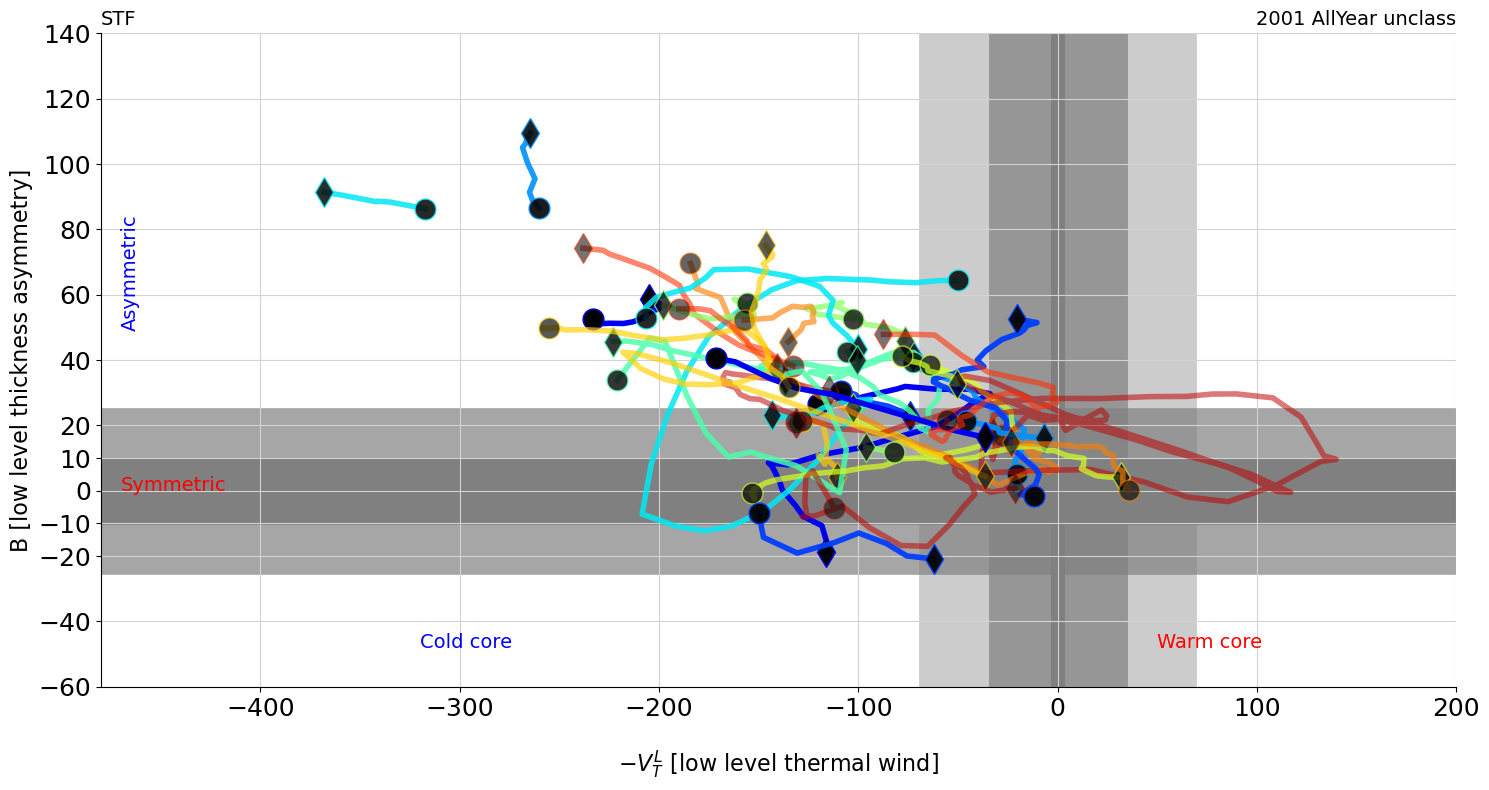

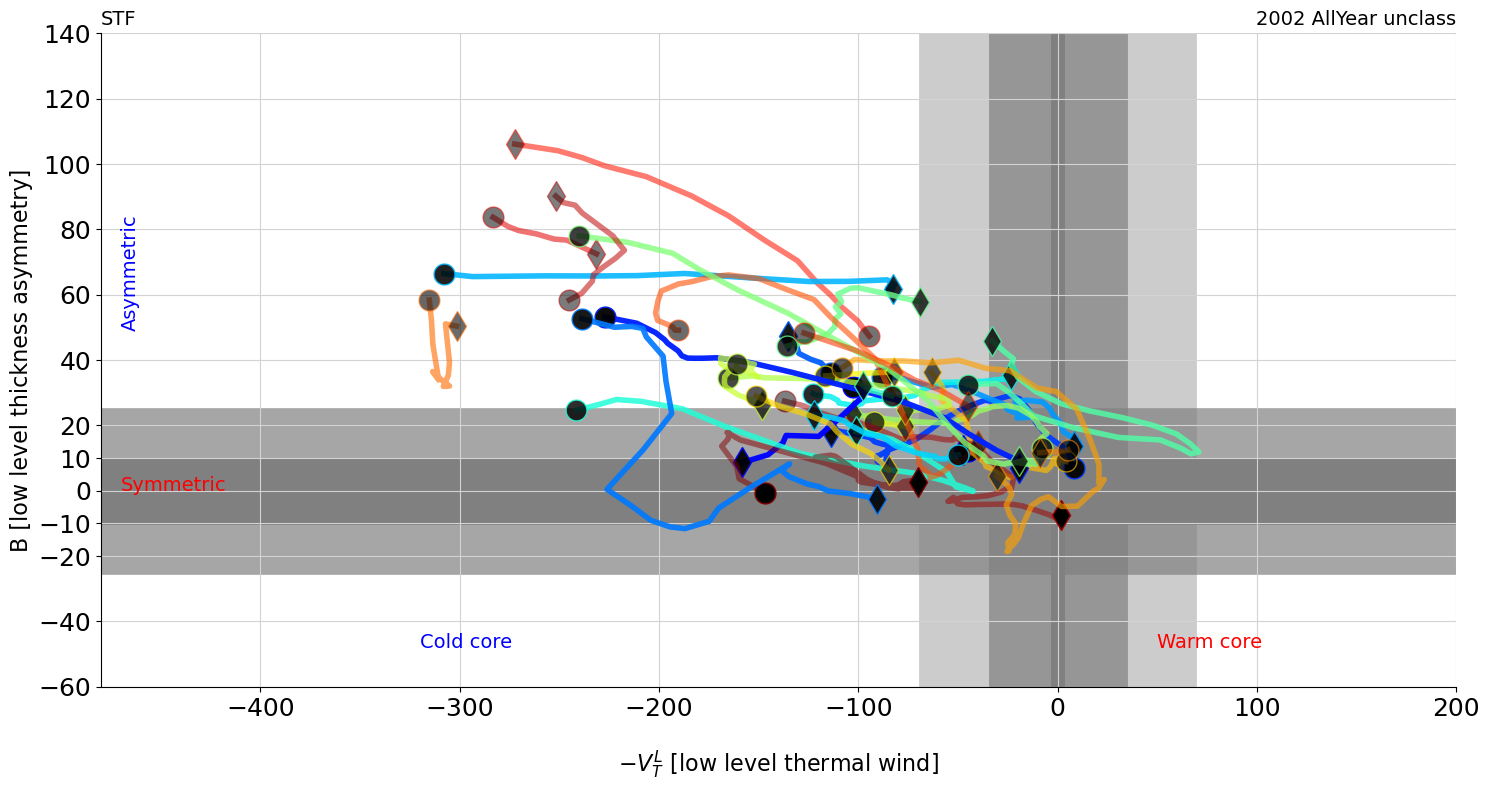

In [59]:
SAVE_FIG_CPS = False
x1=-480
x2=200
y1=-50
y2=125
#CLAS='FCC'

for CLAS in ['unclass']:#(list(dict_cps[ANOi_esc][zone][original_ou_hp][VAR].keys())[:]):

    for ANO in range(ANOi_esc,ANOf_esc+1):

        fig = plt.figure(figsize=(15., 8.))

        ax = fig.add_subplot(111)
        ax.set_title(zone.upper(),loc='left',fontsize=14)
        ax.set_title(str(ANO)+' '+name+' '+CLAS,loc='right',fontsize=14)
        plt.axhline(y=0, color='grey', linewidth=48,zorder=1)
        plt.axhline(y=0, color='grey', linewidth=48*2.5,zorder=1,alpha=0.7)
        plt.axvline(x=0, color='grey', linewidth=10,zorder=1)
        plt.axvline(x=0, color='grey', linewidth=10*10,zorder=1,alpha=0.7)
        plt.axvline(x=0, color='grey', linewidth=10*20,zorder=1,alpha = 0.4)

        IDs_esc = list(dict_pol[ANO][zone][original_ou_hp][VAR][CLAS].keys())

        try:
            plt.gca().set_prop_cycle(plt.cycler(color = plt.cm.jet(np.linspace(0.1,1, len(IDs_esc))),
                                                alpha =           (np.linspace(1,0.5, len(IDs_esc)))))
        except:
            pass

        for S_ID in IDs_esc:

            VTL_series = dict_cps[ANO][zone][original_ou_hp][VAR][CLAS][S_ID][:,-3]
            VTU_series = dict_cps[ANO][zone][original_ou_hp][VAR][CLAS][S_ID][:,-2]
            B_series = dict_cps[ANO][zone][original_ou_hp][VAR][CLAS][S_ID][:,0] 
            plot1, = plt.plot(VTL_series, B_series,lw=4,markersize=10,label=str([i]))
            plt.plot(VTL_series[0], B_series[0], c='k',zorder=2,marker='o',markersize=15,markeredgecolor=plot1.get_color())
            plt.plot(VTL_series[-1], B_series[-1], c='k',zorder=2,marker='d',markersize=15,markeredgecolor=plot1.get_color())


        plt.xlabel("$-V_T^L$ [low level thermal wind]", labelpad=20, fontsize = 16)
        plt.ylabel("B [low level thickness asymmetry]", fontsize = 16)


        plt.text(x1+10,0,'Symmetric', rotation=0., color='red', fontsize = 14)
        plt.text(x1+10, 50,'Asymmetric', rotation=90., color='blue', fontsize = 14)
        plt.text(-320, -48,'Cold core', rotation=0., color='blue', fontsize = 14)
        plt.text(x1+530, -48,'Warm core', rotation=0., color='red', fontsize = 14)
        plt.xlim(x1, x2)
        plt.ylim(y1, y2)
        ticks_y = plt.yticks()[0]
        plt.yticks(np.unique(np.concatenate([ticks_y, [-10, 10]])))

        if SAVE_FIG_CPS:
            try:
                rm.cria_diretorio(folder_path_withbar=dirfigsCFSR,
                                  folder_name_withoutbars='CPS_'+original_ou_hp+'_'+name+'_'+zone)
            except:
                pass


            plt.savefig(dirfigsCFSR+'CPS_'+original_ou_hp+'_'+name+'_'+zone
                        +'/CPS_'+name+'_'+zone+'_'+CLAS+'_'+str(ANO)+'.jpeg',
                        bbox_inches='tight')

        #plt.close()


# DEFINING THE CLASS YOU WANT TO ANALYZE:

In [60]:
CLAS = 'unclass'

# PROPAGATION SPEED

len(lista_vel_avg): 65
Median: 52.0
Mean: 62.0
Soma da PDF (verificação de normalização): 1.0, deve ser igual a 1. Se nao, é porque alguns dados em values_xaxis caem fora do intervalo range_xaxis fornecido (eles não serão considerados no cálculo). Isso reduziria a soma da PDF.


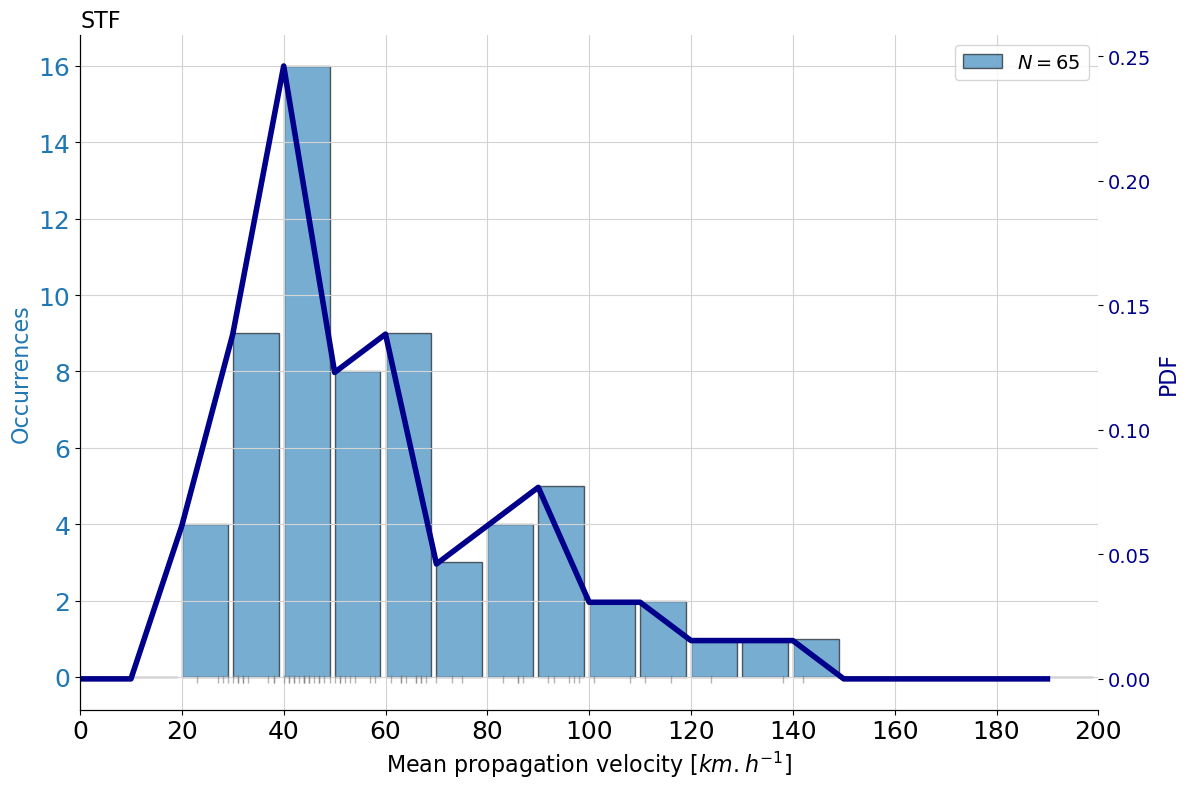

In [61]:
SAVE_VELO = False


lista_vel_avg = []
for ANO in range(ANOi_esc,ANOf_esc+1):
    for S_ID in list((dict_cps[ANO][zone][original_ou_hp][VAR][CLAS].keys())):
        valor=np.nanmean(dict_cps[ANO][zone][original_ou_hp][VAR][CLAS][S_ID][:,-1]).round()
        #print(valor)
        #print()
        lista_vel_avg.append(valor)
        
lista_vel_avg.sort()
print('len(lista_vel_avg):',len(lista_vel_avg))
print('Median:',np.nanmedian(lista_vel_avg).round())
print('Mean:',str(np.nanmean(lista_vel_avg).round()))

pdf, ocorrencias_cada_bin, bin_edges, bin_width = rm.calcula_pdf(values_xaxis = lista_vel_avg,
                                                                 numero_de_bins = 20,range_xaxis=(0,200))#


# Criar a figura e os eixos
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotar o histograma com transparência e cor diferenciada
ax1.bar(
    bin_edges[:-1],
    ocorrencias_cada_bin,
    width=bin_width*0.9,
    color="tab:blue",
    edgecolor="black",
    alpha=0.6,
    align="edge",
    label=f"$N={len(lista_vel_avg)}$",
)

# Eixo Y para ocorrências
ax1.set_xlabel("Mean propagation velocity [$km.h^{-1}$]", fontsize=16)
ax1.set_ylabel("Occurrences", fontsize=16, color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="best", fontsize=14)

# Criar o segundo eixo para a PDF e plotar a curva
ax2 = ax1.twinx()
ax2.plot(bin_edges[:-1], pdf * bin_width, color="darkblue", lw=4, label="PDF")
ax2.set_ylabel("PDF", fontsize=16, color="darkblue")
ax2.tick_params(axis="y", labelcolor="darkblue")

#ax2.spines['right'].set_visible(True)  # Mantém a linha vertical do eixo y2
ax2.yaxis.set_ticks_position('right')  # Garante que os ticks estejam à direita
ax2.grid(False)  # Remove as linhas da grade


# Adicionar rug plots (traços para representar dados individuais)
ax1.plot(lista_vel_avg, [-0.05] * len(lista_vel_avg), '|', color='gray', alpha=0.6, label="Data points")

# Adicionar título e ajustar ticks
plt.xticks(np.arange(0, 201, 20), fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.xlim([0,200])
if CLAS == 'unclass':
    plt.title(zone.upper(),loc='left',fontsize=16)
else:
    plt.title(zone.upper()+', '+CLAS,loc='left',fontsize=16)

# Ajustar o layout e mostrar o gráfico
fig.tight_layout()
plt.show()



if SAVE_VELO:
    fig.savefig(dirfigsCFSR+'Estatistica/Cond'+str(CONDICAO)+'_'+zone+'_Velo_'+CLAS+'_'+name+'_'+str(ANOi)+'a'+str(ANOf)+'.jpeg',bbox_inches='tight')

__________________

# NORMALIZING ALL RADIUS DATA BY TIME


In [ ]:
'''NORMALIZING ALL RADIUS DATA BY TIME'''
new_len=5
dict_norm = {}

for ANO in range(ANOi_esc,ANOf_esc+1):
    print(ANO,ANO,ANO,ANO)
    dict_norm[ANO] = {}
    dict_norm[ANO][zone] = {}
    dict_norm[ANO][zone][original_ou_hp] = {}

    for VAR in VARS[:]:
        print(VAR)
        IDs_esc = list(dict_pol[ANO][zone][original_ou_hp][VAR][CLAS].keys())
        dict_norm[ANO][zone][original_ou_hp][VAR]={}
        dict_norm[ANO][zone][original_ou_hp][VAR][CLAS]={}

        for S_ID in IDs_esc:
            try:
                print('S_ID:',S_ID)
                normalized = np.full(shape=(new_len, len(thetas), len(radii)), fill_value=np.nan)


                for theta in range(len(thetas)):

                    for radius in range(len(radii)):
                        to_norm = dict_pol[ANO][zone][original_ou_hp][VAR][CLAS][S_ID][:,theta,radius]

                        data_interpolada,x_new = rm.interpolate_to_new_len(to_norm,new_len = new_len,interp_kind = 'linear')
                        normalized[:,theta,radius] = data_interpolada



                dict_norm[ANO][zone][original_ou_hp][VAR][CLAS][S_ID] = normalized 

            except Exception as e:
                print(e)

    print(dict_norm.keys())
    print(dict_norm[ANO].keys())
    print(dict_norm[ANO][zone][original_ou_hp][VAR][CLAS].keys())

In [63]:
#CHECKING QUANTITIES
print(dict_pol[ANO][zone][original_ou_hp][VAR].keys())
quant_bombs = []
quant_bombsEC = []

for ANO in range(ANOi_esc,ANOf_esc+1):
    print(ANO)
    print('TC:',len(dict_pol[ANO][zone][original_ou_hp][VAR]['TC'].keys()))
    print('EC:',len(dict_pol[ANO][zone][original_ou_hp][VAR]['EC'].keys()))
    print('F:',len(dict_pol[ANO][zone][original_ou_hp][VAR]['F'].keys()))
    print('NF:',len(dict_pol[ANO][zone][original_ou_hp][VAR]['NF'].keys()))
    print('LWC:',len(dict_pol[ANO][zone][original_ou_hp][VAR]['LWC'].keys()))
    print('LCC:',len(dict_pol[ANO][zone][original_ou_hp][VAR]['LCC'].keys()))
    print('BOMB:',len(dict_pol[ANO][zone][original_ou_hp][VAR]['BOMB'].keys()))
    print('BOMBEC:',len(dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBEC'].keys()))
    
    quant_bombs.append(len(dict_pol[ANO][zone][original_ou_hp][VAR]['BOMB'].keys()))
    quant_bombsEC.append(len(dict_pol[ANO][zone][original_ou_hp][VAR]['BOMBEC'].keys()))
    print('---------------')

dict_keys(['unclass', 'F', 'NF', 'LCC', 'LWC', 'EC', 'TC', 'NFWC', 'FCC', 'NFCC', 'BOMB', 'BOMBF', 'BOMBNF', 'BOMBLCC', 'BOMBLWC', 'BOMBEC', 'BOMBTC'])
2001
TC: 0
EC: 23
F: 0
NF: 0
LWC: 0
LCC: 0
BOMB: 1
BOMBEC: 1
---------------
2002
TC: 0
EC: 20
F: 0
NF: 0
LWC: 0
LCC: 0
BOMB: 2
BOMBEC: 1
---------------


In [31]:
'''SAVE DICT NORM (CLAS)'''

'''-----------------------------------ATENCAO AQUI. ALTERAR PARA NAO SALVAR EM CIMA-----------------------------------'''
SAVE_DICT_NORM = False
'''-----------------------------------ATENCAO AQUI. ALTERAR PARA NAO SALVAR EM CIMA-----------------------------------'''

if SAVE_DICT_NORM:
    print(CLAS)

    if without_refocean:
        pd.to_pickle(dict_norm, dirdadosCFSR+"pkl/dict_norm/CFSR"+VARS_name+"withoutrefocean"+
                     "_"+zone+"_"+name+"_"+CLAS+"_"+str(ANOi)+'a'+str(ANOf)+"_posdef.pkl")
    else:
        pd.to_pickle(dict_norm, dirdadosCFSR+"pkl/dict_norm/CFSR"+VARS_name+"refocean"+
                     str(ref_ocean*3)+"_"+zone+"_"+name+"_"+CLAS+"_"+str(ANOi)+'a'+str(ANOf)+"_posdef.pkl")


In [ ]:
'''READING DICT NORM (CLAS)'''
dict_norm = pd.read_pickle(dirdadosCFSR+"pkl/dict_norm/CFSR"+VARS_name+"refocean"+
                           str(ref_ocean*3)+"_"+zone+"_"+name+"_"+CLAS+"_"+str(ANOi)+'a'+str(ANOf)+".pkl")


__________________________________

# CALCULATING AND PLOTING THE RADIUS COMPOSITE AFTER NORMALIZING BY TIME

$CICLONE$ 

$CLASSES$

In [64]:
'''CALCULATING THE RADIUS COMPOSITE AFTER NORMALIZING BY TIME
-----------------------CLASSIFYING THE TYPE-----------------------'''
tau_comp = {}
tau_comp[zone]={}
tau_comp[zone][original_ou_hp]={}

comp_pol_means = {}
comp_pol_means[zone]={}
comp_pol_means[zone][original_ou_hp]={}
comp_pol_stds = {}
comp_pol_stds[zone]={}
comp_pol_stds[zone][original_ou_hp]={}
comp_pol_medians = {}
comp_pol_medians[zone]={}
comp_pol_medians[zone][original_ou_hp]={}
comp_pol_mads = {}
comp_pol_mads[zone]={}
comp_pol_mads[zone][original_ou_hp]={}


for VAR in VARS[:]:

    tau_comp[zone][original_ou_hp][VAR]={}
    tau_comp[zone][original_ou_hp][VAR][CLAS]={}
    
    comp_pol_means[zone][original_ou_hp][VAR]={} 
    comp_pol_means[zone][original_ou_hp][VAR][CLAS]={} 
    
    comp_pol_stds[zone][original_ou_hp][VAR]={} 
    comp_pol_stds[zone][original_ou_hp][VAR][CLAS]={} 
    
    comp_pol_medians[zone][original_ou_hp][VAR]={} 
    comp_pol_medians[zone][original_ou_hp][VAR][CLAS]={} 
    
    comp_pol_mads[zone][original_ou_hp][VAR]={} 
    comp_pol_mads[zone][original_ou_hp][VAR][CLAS]={} 
    
    print(VAR)

    for tau_idx in range(0,new_len):
        print('\n--------------tau_idx:',tau_idx)
        tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx]=[]    
        
        S_IDs_final = []

        for ANO in range(ANOi_esc,ANOf_esc+1):
            print('  ',ANO,ANO,ANO,ANO)
            IDs_esc = list(dict_norm[ANO][zone][original_ou_hp][VAR][CLAS].keys())

            for S_ID in IDs_esc:
                tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx].append(
                                            dict_norm[ANO][zone][original_ou_hp][VAR][CLAS][S_ID][tau_idx,:,:])
                S_IDs_final.append(str(S_ID)+'_'+str(ANO))


        '''Aqui, o meu tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx] deve ter len, para cada um dos 
        cincos niveis de tempo (normalizacao com new_len=5), igual ao numero total de ciclones escolhidos 
        para todos os anos. 
        Por exemplo, se rodei a celula do CPS com IDs_esc = IDs_dict[ANO][:6] apenas para 2001 e 2002, 
        o shape final da tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx] deve ser (12,37,101)'''
        tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx] = np.array(tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx])
        
        comp_pol_mean = np.nanmean(tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx],axis=0)
        comp_pol_std = np.nanstd(tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx],axis=0)
        comp_pol_median = np.nanmedian(tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx],axis=0)
        comp_pol_mad = stats.median_abs_deviation(tau_comp[zone][original_ou_hp][VAR][CLAS][tau_idx], axis=0,scale='normal',nan_policy='omit')
        
        comp_pol_means[zone][original_ou_hp][VAR][CLAS][tau_idx] = comp_pol_mean
        comp_pol_stds[zone][original_ou_hp][VAR][CLAS][tau_idx] = comp_pol_std
        comp_pol_medians[zone][original_ou_hp][VAR][CLAS][tau_idx] = comp_pol_median
        comp_pol_mads[zone][original_ou_hp][VAR][CLAS][tau_idx] = comp_pol_mad #Calcula o MAD com o ajuste normal (1.4826)

        print('\ncomp_pol_mad:',
                          np.shape(comp_pol_mad))

N = len(S_IDs_final)
N

slp

--------------tau_idx: 0
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)

--------------tau_idx: 1
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)

--------------tau_idx: 2
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)

--------------tau_idx: 3
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)

--------------tau_idx: 4
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)
lh_surf

--------------tau_idx: 0
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)

--------------tau_idx: 1
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)

--------------tau_idx: 2
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)

--------------tau_idx: 3
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)

--------------tau_idx: 4
   2001 2001 2001 2001
   2002 2002 2002 2002

comp_pol_mad: (37, 101)
sst

-------------

65

slp
lh_surf
sst


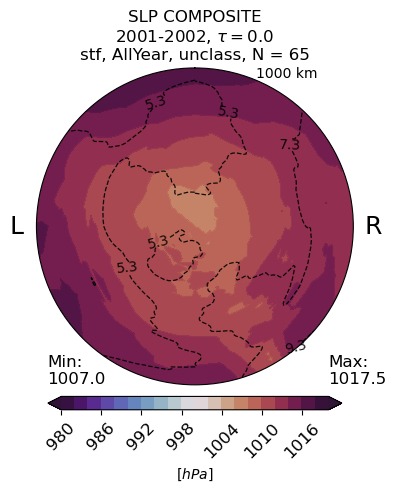

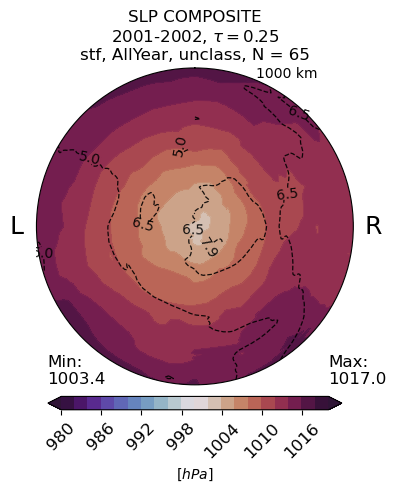

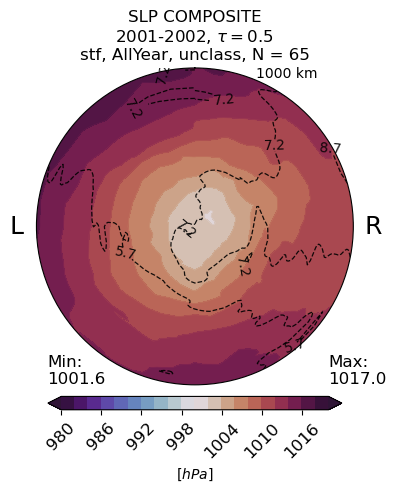

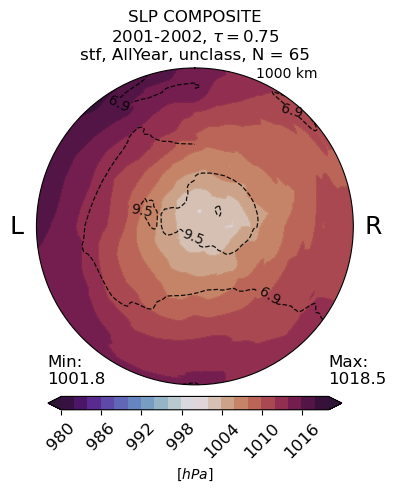

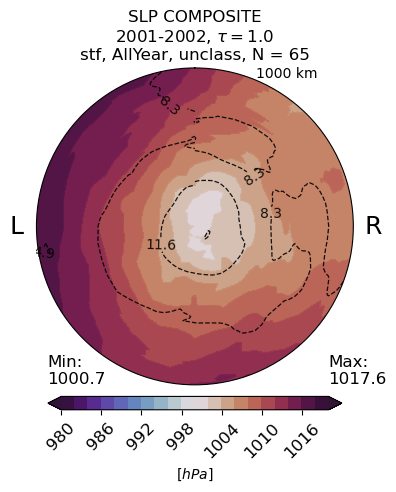

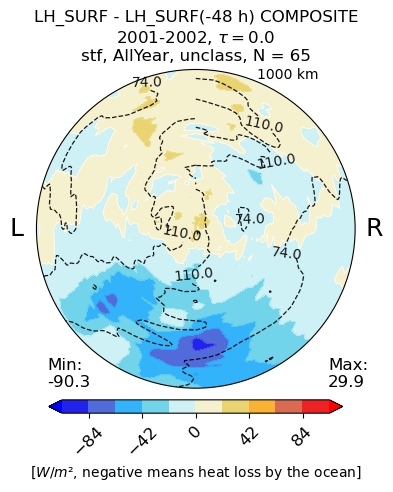

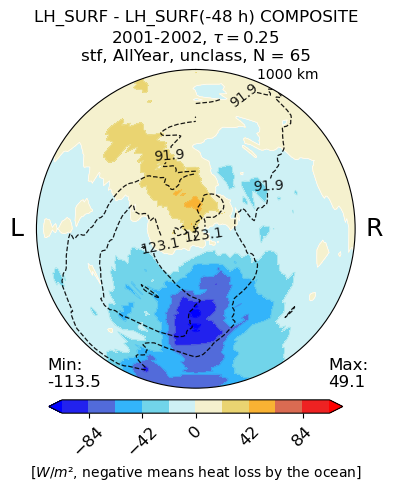

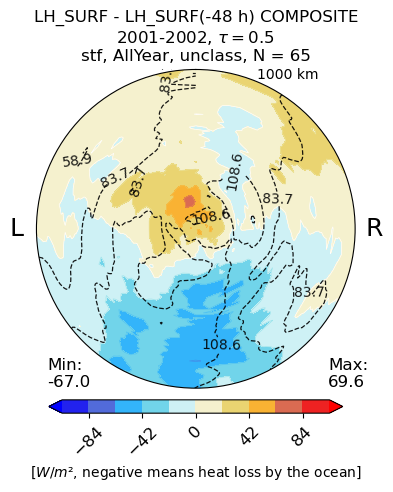

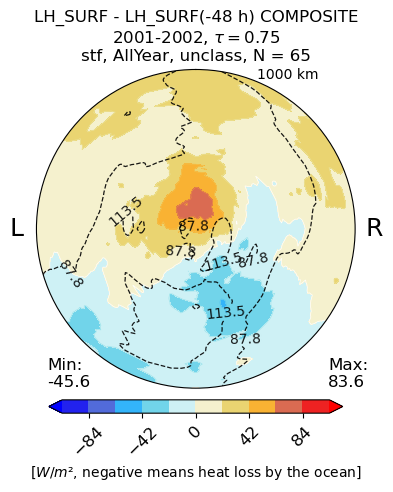

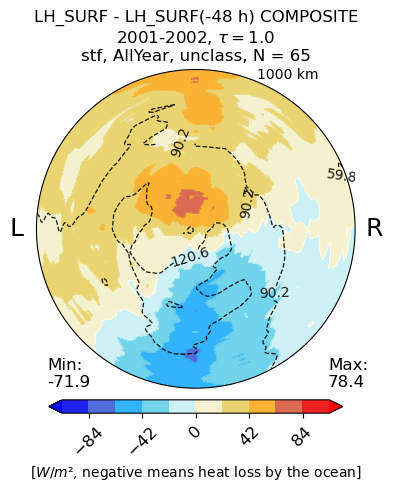

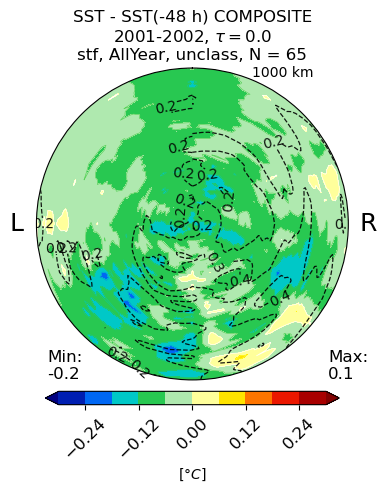

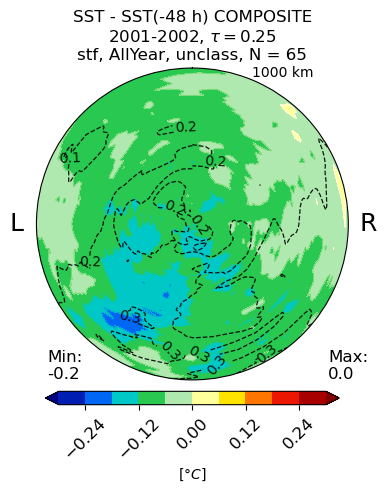

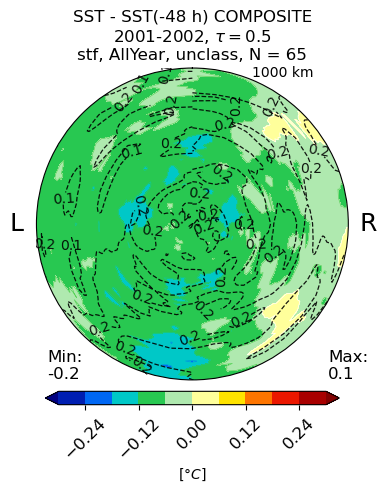

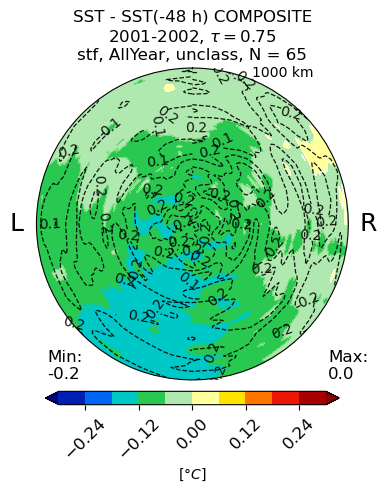

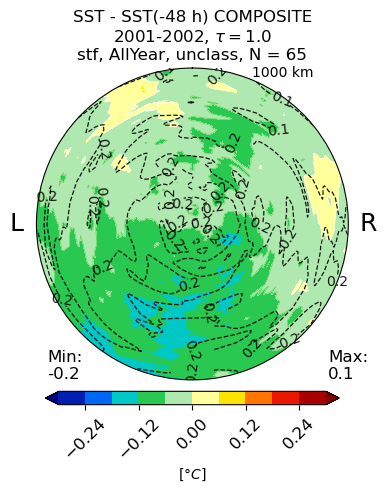

In [65]:
'''PLOTING THE RADIUS COMPOSITE AFTER NORMALIZING BY TIME
-----------------------WITH THE TYPE CLASSIFICATION-----------------------'''
SAVE_FIG_COMP_POL = False
alp = 1.0
ctcolor = 'k'
smo = True
smosave = 'smo_' if smo else ''


for VAR in VARS:

    print(VAR)

    if VAR in ['sst']:
        dz_levels = np.linspace(-0.3,0.3,11) if CLAS in ['EC','BOMB','unclass'] else np.linspace(-1,1,11)
        cmap=rm.turbo_com_branco()
        cbarlabel = '[$°C$]'

    if VAR in ['lh_surf']:
        dz_levels = np.linspace(-155, 155, 11).astype(int) if CLAS in ['TC', 'BOMB'] else np.linspace(-105, 105, 11).astype(int)
        cmap=rm.azul_e_fogo_claro()
        cbarlabel = '[$W/m²$, negative means heat loss by the ocean]'
        
    if VAR == 'slp':
        dz_levels = np.linspace(980,1020,21)        
        cmap='twilight_shifted'
        cbarlabel = '[$hPa$]'
            
    for tau_idx in range(0,new_len):
        
        stat = 'median'
        comp_pol = comp_pol_means[zone][original_ou_hp][VAR][CLAS][tau_idx] if stat == 'mean' else comp_pol_medians[zone][original_ou_hp][VAR][CLAS][tau_idx]
        comp_pol_dev = comp_pol_stds[zone][original_ou_hp][VAR][CLAS][tau_idx] if stat == 'mean' else comp_pol_mads[zone][original_ou_hp][VAR][CLAS][tau_idx]
        max_value_for_ctf = (np.nanmax([np.nanmax(np.abs(arr)) for arr in (comp_pol_means[zone][original_ou_hp][VAR][CLAS]).values()])).round(2) if VAR not in ['wocn_mldb'] else (np.nanmax([np.nanmax(np.abs(arr)) for arr in (comp_pol_means[zone][original_ou_hp][VAR][CLAS]).values()]))
        
        if smo:
            comp_pol_dev = gaussian_filter(comp_pol_dev, sigma=1)#Resample your data grid by a factor of 1 using cubic spline interpolation.
                
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        
        ctf = ax.contourf(theta_grid, r_grid, comp_pol, cmap=cmap, levels=dz_levels,
                          extend='both', alpha=alp,label = 'n = '+str(len(storm_data_final_allyears['ID'].unique())))
    
        cbar=fig.colorbar(ctf, label=cbarlabel,orientation='horizontal',pad=0.03,shrink=0.2)
        cbar.ax.tick_params(labelsize=12,labelrotation=45) 
        
        ct = ax.contour(theta_grid, r_grid, comp_pol, levels=dz_levels,cmap=cmap,extend='both',linewidths=0.5)
    
        dz_levels_dev = np.linspace(np.nanmin(comp_pol_dev)*1.01, np.nanmax(comp_pol_dev)*0.99, 4) #np.linspace(0,np.nanmax(comp_pol_std),4)
        if VAR in ['sst']:
            dz_levels_dev = np.linspace(np.nanmin(comp_pol_dev)*1.1, np.nanmax(comp_pol_dev)*0.9, 4)
        
        ct = ax.contour(theta_grid, r_grid, comp_pol_dev, levels=dz_levels_dev,colors=ctcolor,alpha= 0.9,extend='both',linewidths=0.9,linestyles='--')
        ax.clabel(ct,fontsize=10,fmt=lambda x: f'{x:.1f}',colors=ctcolor,levels=dz_levels_dev,inline=True,inline_spacing=10) 

        ax.set_theta_zero_location("N")  # theta=0 at the top
        ax.set_theta_direction(-1)  # theta increasing clockwise
    
        ax.set_yticks([1000])
        ax.set_yticklabels(['1000 km'],rotation=45,fontsize=10)       # Rótulos personalizados
    
        ax.set_xticks([np.pi/2, 3*np.pi/2])  # Ângulos em radianos para os pontos cardeais
        ax.set_xticklabels(['R', 'L'], rotation=45)  # Rotaciona todos os labels para 45 graus
    
        ax.annotate(xy=(8,1),xycoords = 'axes points',#np.radians(135+90),y=1400,
                     text='Min:\n'+str(np.nanmin(comp_pol).round(1)),
                      fontsize=12)
    
        ax.annotate(xy=(210,1),xycoords = 'axes points',#np.radians(135),y=1400,
                     text='Max:\n'+str((np.nanmax(comp_pol).round(1))),
                      fontsize=12)
    
        ax.grid(False)
    
        if without_refocean or VAR in ['slp']:
            plt.title(VAR.upper()+' COMPOSITE\n'+str(ANOi_esc)+'-'+str(ANOf_esc)+', '+
                  r'$\tau = $' +str(round((tau_idx/(new_len-1)),2))+'\n'+zone+', '+
                  name+', '+CLAS+', N = '+str(N))
            save_refocean = "withoutrefocean"
        else:
            plt.title(VAR.upper()+' - '+VAR.upper()+'(-'+str(ref_ocean*3)+' h) COMPOSITE\n'+str(ANOi_esc)+'-'+str(ANOf_esc)+', '+
                  r'$\tau = $' +str(round((tau_idx/(new_len-1)),2))+'\n'+zone+', '+
                  name+', '+CLAS+', N = '+str(N))
            save_refocean = "refocean"+str(ref_ocean*3)

    
    
        if SAVE_FIG_COMP_POL:
            try:
                rm.cria_diretorio(folder_path_withbar=dirfigsCFSR,
                                  folder_name_withoutbars='PolarComposite_'+original_ou_hp+'_'+name+'_'+zone+
                                                          '_Norm'+str(new_len)+
                                                          '_'+str(ANOi_esc)+'a'+str(ANOf_esc)+'_'+CLAS)
            except:
                pass
    

            plt.savefig(dirfigsCFSR+'PolarComposite_'+original_ou_hp+'_'+name+'_'+zone+
                        '_Norm'+str(new_len)+
                        '_'+str(ANOi_esc)+'a'+str(ANOf_esc)+'_'+CLAS+
                        '/PolarComposite_'+VAR+'_'+name+'_'+zone+'_'+save_refocean+'_tau'+str(tau_idx)+'_'+stat+'_'+smosave+str(ANOi_esc)+'a'+str(ANOf_esc)+'.jpeg',
                        bbox_inches='tight')
            plt.savefig(dirfigsCFSR+'PolarComposite_'+original_ou_hp+'_'+name+'_'+zone+
                        '_Norm'+str(new_len)+
                        '_'+str(ANOi_esc)+'a'+str(ANOf_esc)+'_'+CLAS+
                        '/PolarComposite_'+VAR+'_'+name+'_'+zone+'_'+save_refocean+'_tau'+str(tau_idx)+'_'+stat+'_'+smosave+str(ANOi_esc)+'a'+str(ANOf_esc)+'.png',
                        bbox_inches='tight',format="png", transparent=True)        
        #plt.close()